# Redes Neurais Convolucionais (CNN) - Step by step

<img src='images/cnn_padrao.png' />

1. Importando e configurando pacotes utilizados
2. Função de padding
3. Função de Convolução
4. Função de Ativação
5. Função de Pooling
6. Flattening (extraindo o vetor de características)
7. Definindo a rede neural para a etapa de classificação
8. Função de perda/custo
9. Atualização dos pesos (backpropagation)
10. Treinamento da rede
11. Executando a rede


[Adam W. Harley](http://www.cs.cmu.edu/~aharley/) criou uma ferramenta bem legal para a visualização de uma implementação da Rede LeNet-5 utilizando a seguinte arquitetura de rede:
+ Tamanho da imagem de entrada: 28x28
+ Camada convolucional 01: 6 filtros de 5x5 e stride 1
+ Camada de pooling 01: filtros 2x2 e stride 2
+ Camada convolucional 02: 16 filtros de 5x5 e stride 1 
+ Camada de pooling 02: filtros 2x2 e stride 2
+ Camada FCL 01: 120 nós
+ Camada FCL 02: 100 nós
+ Camada FCL 03: 10 nós
+ Treinamento realizado com a Base MNIST aumentada

Link para a [ferramenta](http://scs.ryerson.ca/~aharley/vis/conv/flat.html).

Link para o [artigo](http://scs.ryerson.ca/~aharley/vis/harley_vis_isvc15.pdf).

# 1 - Importando e configurando pacotes utilizados

- [numpy](http://www.numpy.org) pacote básico para computação científica em Python.
- [matplotlib](http://matplotlib.org) pacote para exibição de gráficos e imagens em Python.
- np.random.seed(1) é utilizado para manter a consistência nas chamadas a funções randômicas.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # tamanho padrão das imagens
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def show_img(img1, img2, img3=None, title1='', title2='', title3='', show_px_value=True):
    """
    Função auxiliar para a visualização das imagens geradas (grupos de 3 imagens).
    """
    
    fig, axarr = plt.subplots(1, (1 if img2 is None else (2 if img3 is None else 3)))
    
    norm_img1 = img1 if img1.shape == (1,1) else (img1-np.min(img1))/(np.max(img1)-np.min(img1))
    if (img2 is not None):
        axarr[0].set_title(title1)
        axarr[0].imshow(norm_img1)
    else:
        axarr.set_title(title1)
        axarr.imshow(norm_img1)
    if (show_px_value == True and img2 is not None):
        for w in range(img1.shape[0]):
            for h in range(img1.shape[1]):
                axarr[0].annotate("{:.1f}".format(img1[w][h]), xy=(h, w),
                            horizontalalignment='center',
                            verticalalignment='center',
                            color='white' if norm_img1[w][h] <= 0.25 or img1.shape == (1,1) else 'black')
    
    
    if (img2 is not None):
        norm_img2 = img2 if img2.shape == (1,1) else (img2-np.min(img2))/(np.max(img2)-np.min(img2))
        axarr[1].set_title(title2)
        axarr[1].imshow(norm_img2, cmap='gray')
        if (show_px_value == True):
            for w in range(img2.shape[0]):
                for h in range(img2.shape[1]):
                    axarr[1].annotate("{:.1f}".format(img2[w][h]), xy=(h, w),
                                horizontalalignment='center',
                                verticalalignment='center',
                                color='white' if norm_img2[w][h] <= 0.25 or img2.shape == (1,1) else 'black')

    if (img3 is not None):
        norm_img3 = img3 if img3.shape == (1,1) else (img3-np.min(img3))/(np.max(img3)-np.min(img3))
        axarr[2].set_title(title3)
        axarr[2].imshow(norm_img3, cmap='gray')
        if (show_px_value == True):
            for w in range(img3.shape[0]):
                for h in range(img3.shape[1]):
                    axarr[2].annotate("{:.1f}".format(img3[w][h]), xy=(h, w),
                                horizontalalignment='center',
                                verticalalignment='center',
                                color='white' if (norm_img3[w][h] <= 0.25 or img3.shape == (1,1)) else 'black')

# 2 - Função de padding


<img src="images/PAD.png" style="width:900px;height:600px;">
    
[Função np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)

In [3]:
def zero_pad(X, pad):
    """
    Completa com zeros todas as imagens da matriz X.
    
    Arguments:
    X -- array numpy de shape (m, n_C, n_H, n_W) representando um lote de 'm' imagens de 'n_C' canais e tamanho 'n_H' x 'n_W'
    pad -- numero inteiro representando o tamanho do padding que sera realizado em toddas as imagens de 'X'
    
    Returns:
    X_pad -- imagem completada com pad de shape (m, n_C, n_H + 2*pad, n_W + 2*pad)
    """
    
    X_pad = np.pad(X, ((0,0), (0,0), (pad,pad), (pad,pad)), 'constant', constant_values = (0,0))
    
    return X_pad

x.shape = (1, 3, 5, 5)
x_pad.shape = (1, 3, 7, 7)


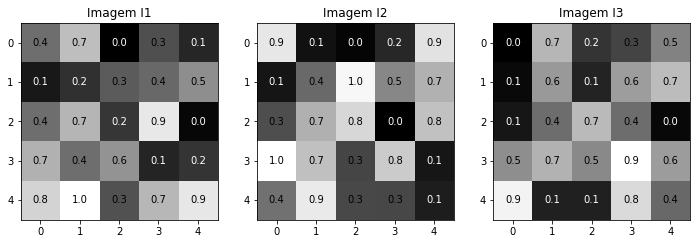

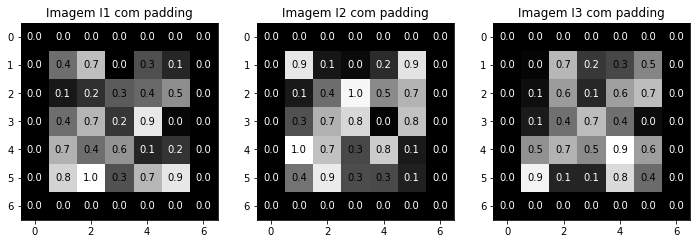

In [4]:
# Gera 1 imagem de 3 canais (RGB) de tamanho 5x5 aleatoriamente 
np.random.seed(1)
x = np.random.rand(1, 3, 5, 5)
print ("x.shape =", x.shape)

# Adiciona o padding de 1 nas imagens geradas aleatoriamente
x_pad = zero_pad(x, 1)
print ("x_pad.shape =", x_pad.shape)

# Exibe as imagens com e sem a aplicacao do padding
show_img(x[0][0], x[0][1], x[0][2], 'Imagem I1', 'Imagem I2', 'Imagem I3')
show_img(x_pad[0][0], x_pad[0][1], x_pad[0][2], 'Imagem I1 com padding', 'Imagem I2 com padding', 'Imagem I3 com padding')
            

# 3 - Função de Convolução

<img src="images/convolucao.gif">

[Função np.multiply](https://docs.scipy.org/doc/numpy/reference/generated/numpy.multiply.html)

[Função np.sum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html)

In [5]:
def conv_single_step(slice_window_prev, W, b):
    """
    Aplica a convolucao do filtro 'W' em uma unica janela 'slice_window_prev' da imagem.
    
    Arguments:
    slice_window_prev -- janela da imagem de shape (n_C, f, f) onde 'n_C' representa a quantidade de canais de uma imagem de tamanho 'f'x'f'
    W -- Filtro (Weight parameters) de convolução de shape igual a janela da imagem (n_C, f, f)
    b -- Bias a ser adicionado no resultado da convolucao - matriz de shape (1, 1, 1)
    
    Returns:
    Z -- um valor escalar, resultado da convolucao do filtro (W, b) na janela da imagem de entrada
    """

    # Multiplica os elementos de 'slice_window_prev' com 'W' (não adiciona o Bias ainda).
    s = np.multiply(slice_window_prev, W)
    # Soma todos os elementos de 's'.
    Z = np.sum(s)
    # Adiciona o Bias a Z (realiza o cast de 'b' para float() para forçar 'Z' retornar um valor escalar).
    Z = Z + b.astype(float)

    return Z

Bias: [[[-2.13483482]]]
Conv. result: [[1.79096919]] + [[3.82477831]] + [[1.00330289]] + [[[-2.13483482]]]
Conv. result: [[[4.48421557]]]


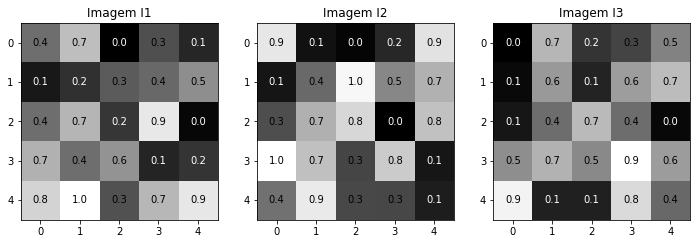

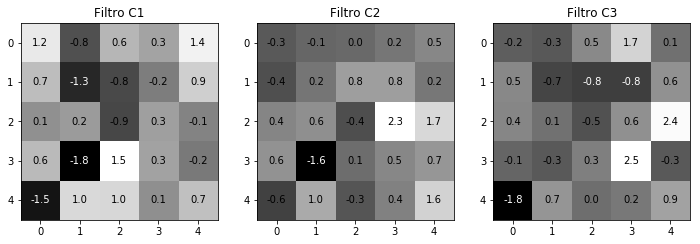

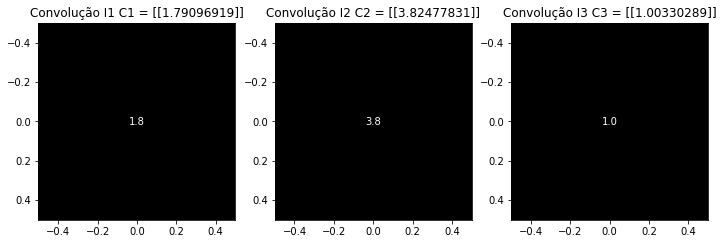

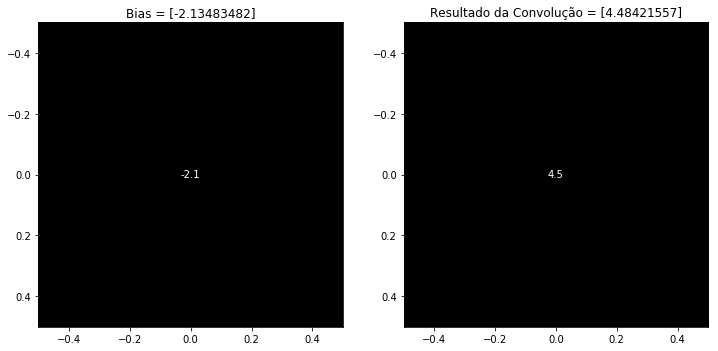

In [6]:
# Gera 1 imagem de 3 canais (RGB) de tamanho 5x5 aleatoriamente
np.random.seed(1)
slice_window_prev = np.random.rand(3, 5, 5)

# Gera 3 filtros de convolucao de tamanho 5x5 aleatoriamente 
W = np.random.randn(3, 5, 5)

# Gera o Bias aletoriamente (será acrescentado na convolução -> Z = W + b )
b = np.random.randn(1, 1, 1)

# Realiza a convolucao de cada canal separadamente para plotar as imagens
conv_c1 = conv_single_step(slice_window_prev[0], W[0], np.zeros((1,1)))
conv_c2 = conv_single_step(slice_window_prev[1], W[1], np.zeros((1,1)))
conv_c3 = conv_single_step(slice_window_prev[2], W[2], np.zeros((1,1)))

# Exibe o resultado das convoluções
show_img(slice_window_prev[0], slice_window_prev[1], slice_window_prev[2], 'Imagem I1', 'Imagem I2', 'Imagem I3')
show_img(W[0], W[1], W[2], 'Filtro C1', 'Filtro C2', 'Filtro C3')
show_img(conv_c1, conv_c2, conv_c3, f'Convolução I1 C1 = {conv_c1}', f'Convolução I2 C2 = {conv_c2}', f'Convolução I3 C3 = {conv_c3}')

# Calcula a convolução completa
Z = conv_single_step(slice_window_prev, W, b)
show_img(b[0], Z[0], None, f'Bias = {b[0][0]}', f'Resultado da Convolução = {Z[0][0]}')

print(f'Bias: {b}')
print(f'Conv. result: {conv_c1} + {conv_c2} + {conv_c3} + {b}')
print(f'Conv. result: {Z}')

In [7]:
def conv_forward(X, W, b, hparameters):
    """
    Implementa a função de convolução
    
    Arguments:
    X -- imagem a ser aplicada a convolução (imagem de saida da camada anterior), numpy array de shape (m, n_C, n_H, n_W) representando um lote de 'm' imagens de 'n_C' canais e tamanho 'n_H' x 'n_W'
    W -- Filtros (Weight parameters) de convolução de shape (n_C, n_C_prev, f, f) onde 'n_C_prev' representa a quantidade de canais de entrada, 'f'x'f' o tamanho do filtro e 'n_C' a quantidade de canais de saida
    b -- Biases, numpy array de shape (n_C, 1, 1, 1)
    hparameters -- objeto (python dictionary) contendo os valores de "stride" and "padding"
        
    Returns:
    Z -- saida da convolução, numpy array de shape (m, n_C, n_H, n_W)
    cache -- cache com os valores de entrada a ser utilizado no backpropagation (conv_backward())
    """
    
    # Recupera as informações de shape das imagens de entrada
    (m, n_C_prev, n_H_prev, n_W_prev) = X.shape
    
    # Recupera as informações de shape dos filtros de convolução
    (n_C, n_C_prev, f, f) = W.shape
    
    # Recupera as informações de stride e padding 
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Calcula as dimensões 'n_H' e 'n_W' de saida da convolução
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1
    
    # Inicializa o volume de saida 'Z' com zeros
    Z = np.zeros([m, n_C, n_H, n_W])
    
    # Realiza o padding nas imagens, caso necessário
    X_pad = zero_pad(X, pad)
    
    for i in range(m):                      # itera sobre o lote de exemplos de treinamento
        x_pad = X_pad[i,:,:,:]              # seleciona o ith exemplo de treinamento
        for c in range(n_C):                # itera sobre os canais do volume de saida
            for h in range(n_H):            # itera sobre o eixo vertical do volume de saida
                for w in range(n_W):        # itera sobre o eixo horizontal do volume de saida
                    
                    # encontra os cantos da janela do filtro
                    vert_start = h*stride
                    vert_end = h*stride + f
                    horiz_start = w*stride 
                    horiz_end = w*stride + f
                    
                    # Encontra a janela para a aplicação do filtro de convolução
                    a_slice = x_pad[:,vert_start:vert_end,horiz_start:horiz_end]
                    
                    # Aplica o filtro de convolução
                    Z[i, c, h, w] = conv_single_step(a_slice, W[c, :, :, :], b[c,:,:,:])
    
    # Verificando se o shape da saida está correto
    assert(Z.shape == (m, n_C, n_H, n_W))
    
    # Guarda a passagem em cache para ser utilizado no backpropagation
    cache = (X, W, b, hparameters)
    
    return Z, cache

### Executando a função de convolução criada

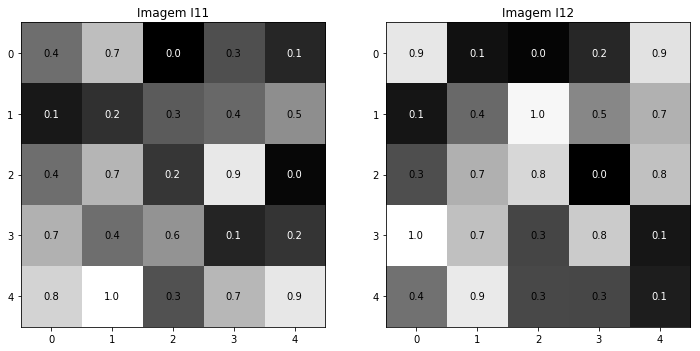

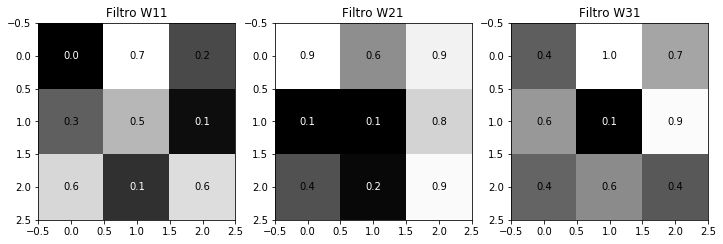

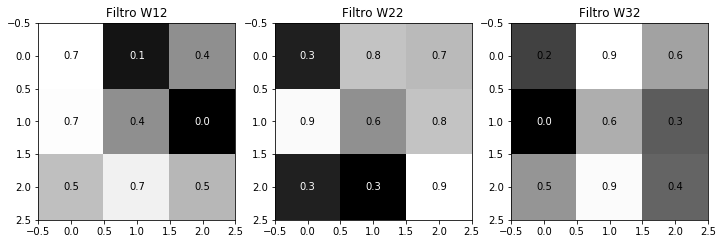

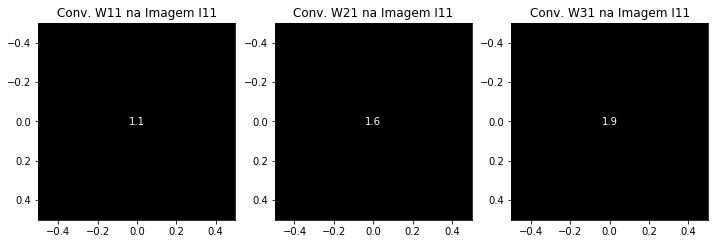

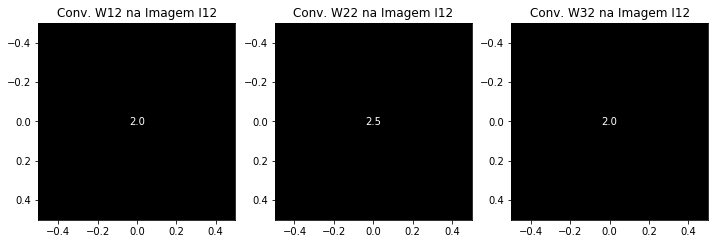

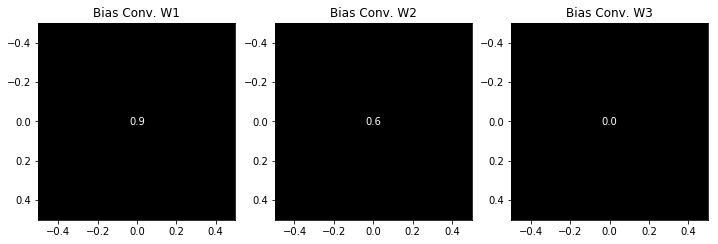

In [8]:
np.random.seed(1)
X = np.random.rand(1,2,5,5)
W = np.random.rand(3,2,3,3)
b = np.random.rand(3,1,1,1)
hparameters = {"pad" : 0, "stride": 1}

# Exibe as 2 imagens geradas aleatoriamente (1 imagem de 2 canais)
show_img(X[0][0], X[0][1], None, 'Imagem I11', 'Imagem I12', '')

# Exibe os 3 filtros de 2 dimensoes gerados aleatorimente
show_img(W[0][0], W[1][0], W[2][0], 'Filtro W11', 'Filtro W21', 'Filtro W31')
show_img(W[0][1], W[1][1], W[2][1], 'Filtro W12', 'Filtro W22', 'Filtro W32')

# Exibe o resultado da aplicação de uma única janela de convolução dos filtros W11 e W12 nas imagens I11 e I12
# Primeiro pixel (canto superior esquerdo)
conv_w1_i1 = conv_single_step(X[0][0][0:3, 0:3], W[0][0], np.zeros((1,1)))
conv_w4_i1 = conv_single_step(X[0][1][0:3, 0:3], W[0][1], np.zeros((1,1)))

# Exibe o resultado da aplicação de uma única janela de convolução dos filtros W21 e W22 nas imagens I11 e I12
# Primeiro pixel (canto superior esquerdo)
conv_w2_i1 = conv_single_step(X[0][0][0:3, 0:3], W[1][0], np.zeros((1,1)))
conv_w5_i1 = conv_single_step(X[0][1][0:3, 0:3], W[1][1], np.zeros((1,1)))

# Exibe o resultado da aplicação de uma única janela de convolução dos filtros W31 e W32 nas imagens I11 e I12
# Primeiro pixel (canto superior esquerdo)
conv_w3_i1 = conv_single_step(X[0][0][0:3, 0:3], W[2][0], np.zeros((1,1)))
conv_w6_i1 = conv_single_step(X[0][1][0:3, 0:3], W[2][1], np.zeros((1,1)))


show_img(conv_w1_i1, conv_w2_i1, conv_w3_i1, 'Conv. W11 na Imagem I11', 'Conv. W21 na Imagem I11', 'Conv. W31 na Imagem I11')
show_img(conv_w4_i1, conv_w5_i1, conv_w6_i1, 'Conv. W12 na Imagem I12', 'Conv. W22 na Imagem I12', 'Conv. W32 na Imagem I12')
show_img(b[0][0], b[1][0], b[2][0], 'Bias Conv. W1', 'Bias Conv. W2', 'Bias Conv. W3')


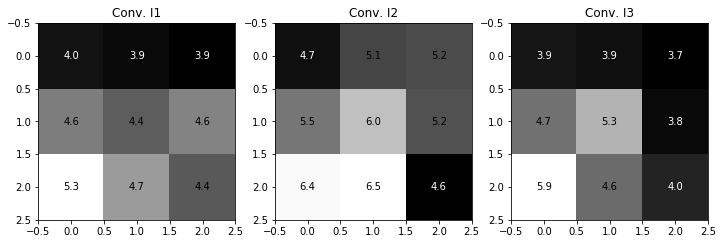

In [9]:
# Executando a convolução completa na imagem por meio do método criado
Z, cache_conv = conv_forward(X, W, b, hparameters)

show_img(Z[0][0], Z[0][1], Z[0][2], 'Conv. I1', 'Conv. I2', 'Conv. I3')


### Executando a função de convolução por meio do framework PyTorch

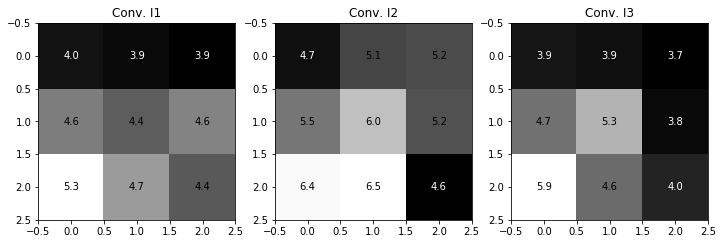

In [10]:
# Executando a convolução completa na imagem por meio do framework PyTorch
# Verificando que o resultado é o mesmo do nosso método criado...

import torch
import torch.nn as nn

# Cria no PyTorch as duas imagens de entrada iguais as imagens geradas aleatoriamente anteriormente
input_conv_pytorch = torch.from_numpy(X).type(torch.FloatTensor)
# Cria no PyTorch o Bias igual ao Bias gerado aleatoriamente anteriormente
bias_conv_pytorch = torch.from_numpy(np.array([b[0][0][0][0], b[1][0][0][0], b[2][0][0][0]])).type(torch.FloatTensor)
# Cria no PyTorch os filtros de convolução iguais aos filtros gerados aleatoriamente anteriormente
filter_conv_pytorch = torch.from_numpy(W).type(torch.FloatTensor)

# Cria a camada de convolução no PyTorch
conv_pytorch = nn.Conv2d(2, 3, kernel_size=3, bias=True)
# Especifica os filtros
conv_pytorch.weight = torch.nn.Parameter(filter_conv_pytorch)
# Especifica o Bias
conv_pytorch.bias = torch.nn.Parameter(bias_conv_pytorch)

# Executa a camada de convolução no PyTorch
output_conv_pytorch = conv_pytorch(input_conv_pytorch)

# Exibe o resultado
show_img(output_conv_pytorch[0][0].detach().numpy(), output_conv_pytorch[0][1].detach().numpy(), output_conv_pytorch[0][2].detach().numpy(), 'Conv. I1', 'Conv. I2', 'Conv. I3')

# 4 - Função de Ativação

<img src="images/relu.jpeg" style="width:500px;height:200px;">

In [11]:
def relu(Z, derivative=False):
    """
    Implementação da função de ativação ReLU
    
    Arguments:
    Z -- imagem a ser aplicada a função de ativação ReLU
    
    Returns:
    A -- saida da função de ativação ReLU
    """
    if (derivative == True):
        return np.where(Z <= 0, 0, 1)
        
    return np.maximum(Z, 0, Z)

In [12]:
def tanh(Z, derivative=False):
    """
    Implementação da função de ativação Tangent Hiperbolica
    
    Arguments:
    Z -- imagem a ser aplicada a função de ativação tanh
    
    Returns:
    A -- saida da função de ativação tanh
    """
    if (derivative == True):
        return (1 - (Z ** 2))
    
    return np.tanh(Z)

In [13]:
def sigmoid(Z, derivative=False):
    """
    Implementação da função de ativação Sigmoid
    
    Arguments:
    Z -- imagem a ser aplicada a função de ativação Sigmoid
    
    Returns:
    A -- saida da função de ativação Sigmoid
    """
    if (derivative == True):
        return Z * (1 - Z)
    
    return 1/(1 + np.exp(-Z))

In [14]:
def softmax(Z, derivative=False):
    """
    Implementação da função de ativação softmax
    
    Arguments:
    Z -- imagem a ser aplicada a função de ativação softmax
    
    Returns:
    A -- saida da função de ativação
    """
    e_Z = np.exp(Z)
    return e_Z / np.sum(e_Z)


# 5 - Função de Pooling

<img src="images/maxpool_animation.gif" style="width:500px;height:200px;">


In [15]:
def pool_forward(X, hparameters, mode = "max"):
    """
    Implementa a função de pooling
    
    Arguments:
    X -- imagem a ser aplicada o pooling (imagem de saida da camada anterior), numpy array de shape (m, n_C, n_H, n_W) representando um lote de 'm' imagens de 'n_C' canais e tamanho 'n_H' x 'n_W'
    hparameters -- objeto (python dictionary) contendo os valores de "stride" e o tamanho da máscara 'f'
    mode -- tipo da função de pooling ('max' ou 'average')
        
    Returns:
    A -- imagem de saída da função de pooling, numpy array de shape (m, n_C, n_H, n_W)
    cache -- cache com os valores de entrada a ser utilizado no backpropagation (pool_backward())
    """
    
    # Recupera as dimensões da imagem
    (m, n_C_prev, n_H_prev, n_W_prev) = X.shape
    
    # Recupera os parametros 'stride' e tamanho da máscara 'f'x'f'
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define as dimensões da imagem de saida
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Inicializa a matriz de saída 'A'
    A = np.zeros((m, n_C, n_H, n_W))
    
    for i in range(m):                 # itera sobre os exemplos de treinamento
        for c in range (n_C):          # itera sobre os canais do volume de saída
            for h in range(n_H):       # itera sobre o eixo vertical do volume de saída
                for w in range(n_W):   # itera sobre o eixo horizontal do voume de saída
                    
                    # encontra os cantos da janela da mácara de pooling
                    vert_start = h*stride
                    vert_end = h*stride +f
                    horiz_start = w*stride
                    horiz_end = w*stride + f
                    
                    # Encontra a janela para a aplicação da função de pooling
                    x_slice = X[i, c, vert_start:vert_end, horiz_start:horiz_end]
                    
                    # Aplica a operação de pooling
                    if mode == "max":
                        A[i, c, h, w] = np.max(x_slice)
                    elif mode == "average":
                        A[i, c, h, w] = np.mean(x_slice)
    
    # Guarda a passagem em cache para ser utilizado no backpropagation
    cache = (X, hparameters)
    
    # Verificando se o shape da saida está correto
    assert(A.shape == (m, n_C, n_H, n_W))
    
    return A, cache

### Executando a função de pooling criada

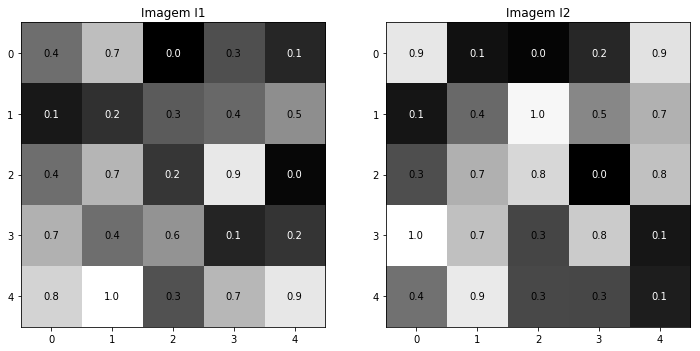

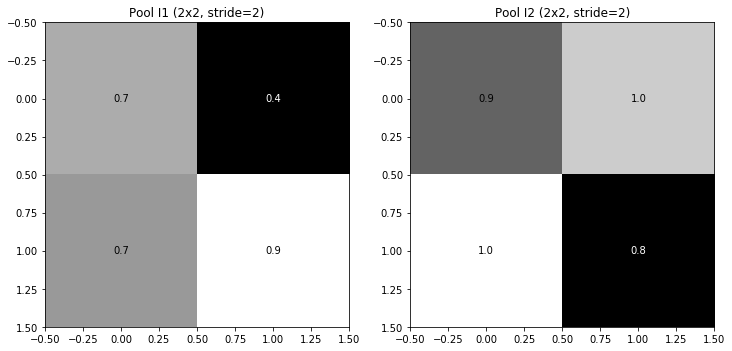

In [16]:
np.random.seed(1)
X = np.random.rand(1,2,5,5)
hparameters = {"stride" : 2, "f": 2}

A, cache_pool = pool_forward(X, hparameters)

# Exibe as 2 imagens geradas aleatoriamente
show_img(X[0][0], X[0][1], None, 'Imagem I1', 'Imagem I2', '')
# Exibe a saída da camada de pooling
show_img(A[0][0], A[0][1], None, 'Pool I1 (2x2, stride=2)', 'Pool I2 (2x2, stride=2)', '')

### Executando a função de pooling por meio do framework PyTorch

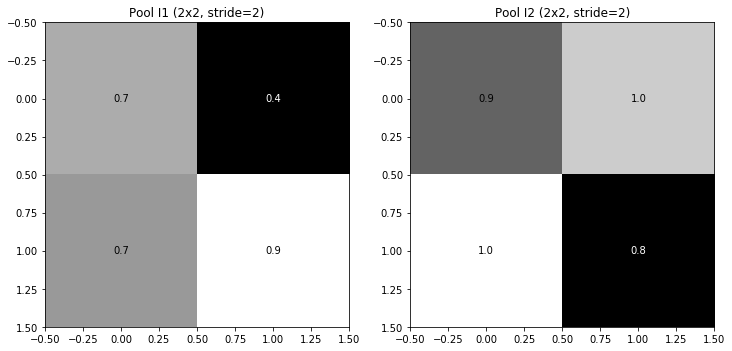

In [17]:
# Executando o pooling na imagem por meio do framework PyTorch
# Verificando que o resultado é o mesmo do nosso método criado...

import torch
import torch.nn as nn

# Cria no PyTorch as duas imagens de entrada iguais as imagens geradas aleatoriamente anteriormente
input_pool_pytorch = torch.from_numpy(X).type(torch.FloatTensor)

# Cria a camada de pooling no PyTorch
pool_pytorch = nn.MaxPool2d(kernel_size=2, stride=2)

# Executa a camada de polling no PyTorch
output_pool_pytorch = pool_pytorch(input_pool_pytorch)

# Exibe o resultado
show_img(output_pool_pytorch[0][0].detach().numpy(), output_pool_pytorch[0][1].detach().numpy(), None, 'Pool I1 (2x2, stride=2)', 'Pool I2 (2x2, stride=2)', '')

# 6 - Flattening (extraindo o vetor de características)

In [18]:
def flatten(X):
    """
    Transforma a matriz n-dimensional 'x' em um vetor de características.
    """
    #return X.flatten()
    #return X.reshape((X.shape[0], 1))
    #return X.reshape(X.shape[0], -1).T
    return X.reshape(X.shape[0], -1)

### Executando a função de flattening criada

A.shape: (1, 3, 2, 2)
Vetor de características extraído: (1, 12)
[[5.3780186  5.81755239 6.59059143 6.48067266 4.16269701 4.49481852
  4.83600758 5.70835347 4.06989442 4.08254349 4.8753804  5.3168844 ]]


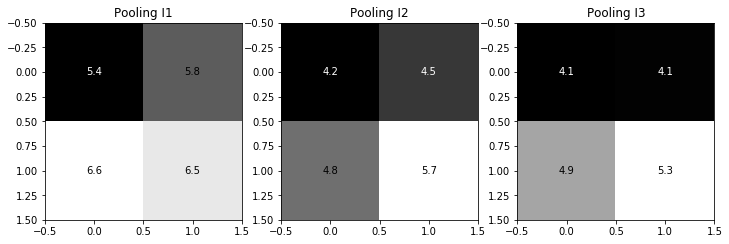

In [19]:
np.random.seed(1)
X = np.random.rand(1,2,7,7)
W = np.random.rand(3,2,3,3)
b = np.random.rand(3,1,1,1)
hparameters = {"pad" : 0, "stride": 1}

Z, cache_conv = conv_forward(X, W, b, hparameters)
A = relu(Z)

hparameters = {"stride" : 2, "f": 2}
A, cache_pool = pool_forward(A, hparameters)

# Exibe a saída da camada de pooling
show_img(A[0][0], A[0][1], A[0][2], 'Pooling I1', 'Pooling I2', 'Pooling I3')

FEAT = flatten(A)
print(f'A.shape: {A.shape}')
print(f'Vetor de características extraído: {FEAT.shape}')
print(FEAT)

### Executando a função de flattening por meio do framework PyTorch

Vetor de características extraído: torch.Size([1, 12])
tensor([[5.3780, 5.8176, 6.5906, 6.4807, 4.1627, 4.4948, 4.8360, 5.7084, 4.0699,
         4.0825, 4.8754, 5.3169]], grad_fn=<ViewBackward>)


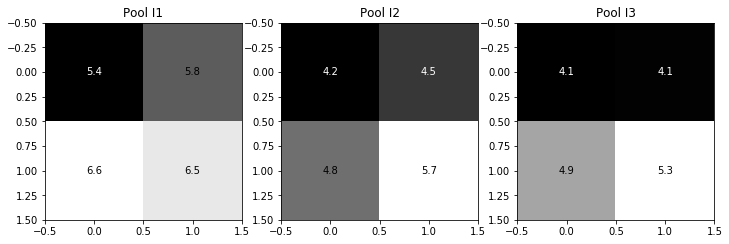

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(1)
X = np.random.rand(1,2,7,7)
W = np.random.rand(3,2,3,3)
b = np.random.rand(3,1,1,1)

# Cria no PyTorch as duas imagens de entrada iguais as imagens geradas aleatoriamente anteriormente
input_conv_pytorch = torch.from_numpy(X).type(torch.FloatTensor)
# Cria no PyTorch o Bias igual ao Bias gerado aleatoriamente anteriormente
bias_conv_pytorch = torch.from_numpy(np.array([b[0][0][0][0], b[1][0][0][0], b[2][0][0][0]])).type(torch.FloatTensor)
# Cria no PyTorch os filtros de convolução iguais aos filtros gerados aleatoriamente anteriormente
filter_conv_pytorch = torch.from_numpy(W).type(torch.FloatTensor)

# Cria a camada de convolução no PyTorch
conv_pytorch = nn.Conv2d(2, 3, kernel_size=3, bias=True)
# Especifica os filtros
conv_pytorch.weight = torch.nn.Parameter(filter_conv_pytorch)
# Especifica o Bias
conv_pytorch.bias = torch.nn.Parameter(bias_conv_pytorch)

# Cria a camada de pooling no PyTorch
pool_pytorch = nn.MaxPool2d(kernel_size=2, stride=2)

# Executa as camadas de convolução, relu e pooling no PyTorch
output_conv_pytorch = conv_pytorch(input_conv_pytorch)
output_relu_pytorch = F.relu(output_conv_pytorch)
output_pool_pytorch = pool_pytorch(output_relu_pytorch)


show_img(output_pool_pytorch[0][0].detach().numpy(), output_pool_pytorch[0][1].detach().numpy(), output_pool_pytorch[0][2].detach().numpy(), 'Pool I1', 'Pool I2', 'Pool I3')
features_pytorch = output_pool_pytorch.view(output_pool_pytorch.size(0), -1)#.detach().numpy()[0]
print(f'Vetor de características extraído: {features_pytorch.shape}')
print(features_pytorch)

# 7 - Definindo a rede neural para a etapa de classificação

<img src='images/cnn_mnist_arq.png' />

[Função np.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html)

In [21]:
# definindo as camadas da rede
nn_architecture = [
    {"input_dim": 120, "output_dim": 84, "activation": "relu"},
    {"input_dim": 84, "output_dim": 10, "activation": "softmax"}
]
print(nn_architecture)

[{'input_dim': 120, 'output_dim': 84, 'activation': 'relu'}, {'input_dim': 84, 'output_dim': 10, 'activation': 'softmax'}]


In [22]:
def init_layers(nn_architecture, seed = 1, debug = False):
    
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    nn_params_values = {}
    
    for idx, layer in enumerate(nn_architecture):

        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        W_name = 'W' + str(layer_idx)
        b_name = 'b' + str(layer_idx)
        #nn_params_values[W_name] = np.random.randn(layer_output_size, layer_input_size) * 0.01
        #nn_params_values[b_name] = np.random.randn(layer_output_size, 1) * 0.01
        nn_params_values[W_name] = np.random.uniform(size=(layer_output_size, layer_input_size))
        nn_params_values[b_name] = np.random.uniform(size=(layer_output_size, 1))

        if (debug):
            print(f"{W_name}.shape: {nn_params_values[W_name].shape}")
            print(f"{b_name}.shape: {nn_params_values[b_name].shape}")
            print('-')
        
    return nn_params_values

In [23]:
# gera os pesos e bias das camadas da rede aleatoriamente
nn_params_values = init_layers(nn_architecture, debug=True)

W1.shape: (84, 120)
b1.shape: (84, 1)
-
W2.shape: (10, 84)
b2.shape: (10, 1)
-


In [24]:
def nn_forward_single(X, W, b, activation="sigmoid"):
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    elif activation is "tanh":
        activation_func = tanh
    else:
        activation_func = softmax
    
    Z = np.dot(W, X) + b
    A = activation_func(Z)
    
    assert(Z.shape == (W.shape[0], X.shape[1]))
    
    return A, Z

In [25]:
def nn_forward_full(X, nn_params_values, nn_architecture, debug=False):
    
    if (debug):
        print(f"X.shape: {X.shape}")
        print('-')
    
    # Guarda a passagem em cache para ser utilizado no backpropagation
    cache = {}
    
    A_curr = X
    cache["A0"] = A_curr
    
    # itera sobre as camadas da rede
    for idx, layer in enumerate(nn_architecture):
        
        # nomeamos as camadas a partir de 1
        layer_idx = idx + 1
        
        # valores de entrada passam a ser a saida da camada anterior
        A_prev = A_curr
        if (debug):
            print(f'A{str(idx)}.shape: {A_prev.shape}')
        
        # funcao de ativacao a ser executada na camada atual
        activ_function_curr = layer["activation"]
        
        # pesos da camada atual
        W_curr = nn_params_values["W" + str(layer_idx)]
        
        # bias da camada atual
        b_curr = nn_params_values["b" + str(layer_idx)]
        
        # executa uma passagem na camada atual
        A_curr, Z_curr = nn_forward_single(A_prev, W_curr, b_curr, activ_function_curr)
        
        # guarda a passagem em cache
        cache["W" + str(layer_idx)] = W_curr
        cache["b" + str(layer_idx)] = b_curr
        cache["Z" + str(layer_idx)] = Z_curr
        cache["A" + str(layer_idx)] = A_curr
    
    cache["A" + str(len(nn_architecture))] = A_curr
    if (debug):
        print(f'A{len(nn_architecture)}.shape: {A_curr.shape}')
        print('-')
    
    # retorna a saida da ultima camada da rede e um cache com os valores de cada camada
    return A_curr, cache

### Executando a rede neural criada

In [57]:
def print_cache(cache, nn_architecture):
    
    print('------------ cache ------------')
    print(f"X/A0: \n{cache['A0']}")
    for layer_idx, layer in enumerate(nn_architecture, 1):
    
        print('-')
        print(f"W{layer_idx}: \n{cache['W' + str(layer_idx)]}")
        print(f"b{layer_idx}: \n{cache['b' + str(layer_idx)]}")
        print(f"Z{layer_idx}: \n{cache['Z' + str(layer_idx)]}")
        print(f"A{layer_idx}: \n{cache['A' + str(layer_idx)]}")
    print('-------------------------------')

def print_params(nn_params_values, nn_architecture):
    
    print('------------ params ------------')
    for layer_idx, layer in enumerate(nn_architecture, 1):
        print('-')
        print(f"W{layer_idx}: \n{nn_params_values['W' + str(layer_idx)]}")
        print(f"b{layer_idx}: \n{nn_params_values['b' + str(layer_idx)]}")
    print('--------------------------------')
              
def print_delta(delta_values, nn_architecture):
    
    print('------------ delta ------------')
    for layer_idx, layer in enumerate(nn_architecture, 1):
        print('-')
        print(f"dZ{layer_idx}: \n{delta_values['dZ' + str(layer_idx)]}")
        print(f"dW{layer_idx}: \n{delta_values['dW' + str(layer_idx)]}")
        print(f"db{layer_idx}: \n{delta_values['db' + str(layer_idx)]}")
    print('--------------------------------')

In [27]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
    {"input_dim": 1, "output_dim": 1, "activation": "sigmoid"}
]
nn_params_values = init_layers(nn_architecture)
print(f'nn_architecture: {nn_architecture}')
print()
    
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]]).T
print(f'X.shape: {X.shape} \n{X}')
print()

y = np.array([[0, 
               1, 
               1, 
               0]])
print(f"y.shape: {y.shape} \n{y}")

y_hat, cache = nn_forward_full(X, nn_params_values, nn_architecture)
print()
print(f"y_hat: {y_hat.shape} \n{y_hat}")
print()
print_cache(cache, nn_architecture)

nn_architecture: [{'input_dim': 2, 'output_dim': 1, 'activation': 'sigmoid'}, {'input_dim': 1, 'output_dim': 1, 'activation': 'sigmoid'}]

X.shape: (2, 4) 
[[0 0 1 1]
 [0 1 0 1]]

y.shape: (1, 4) 
[[0 1 1 0]]

y_hat: (1, 4) 
[[0.57393661 0.58665059 0.58151636 0.59283222]]

------------ cache ------------
X/A0: 
[[0 0 1 1]
 [0 1 0 1]]
-
W1: 
[[0.417022   0.72032449]]
b1: 
[[0.00011437]]
Z1: 
[[1.14374817e-04 7.20438868e-01 4.17136380e-01 1.13746087e+00]]
A1: 
[[0.50002859 0.67270365 0.60279781 0.75721315]]
-
W2: 
[[0.30233257]]
b2: 
[[0.14675589]]
Z2: 
[[0.29793082 0.35013612 0.3290013  0.37568609]]
A2: 
[[0.57393661 0.58665059 0.58151636 0.59283222]]
-------------------------------


### Executando a rede neural por meio do framework PyTorch

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

relu_pytorch = nn.ReLU()
sigmoid_pytorch = nn.Sigmoid()
softmax_pytorch = nn.Softmax(dim=1)

# Conversao de dados para o PyTorch
input_nn_pytorch = torch.from_numpy(X).type(torch.FloatTensor)
input_nn_pytorch = input_nn_pytorch.view(input_nn_pytorch.size(1), -1)
W1_nn_pytorch = torch.from_numpy(nn_params_values['W1']).type(torch.FloatTensor)
b1_nn_pytorch = torch.from_numpy(nn_params_values['b1']).type(torch.FloatTensor)
b1_nn_pytorch = b1_nn_pytorch.view(b1_nn_pytorch.size(1), -1)

layer1 = nn.Linear(W1_nn_pytorch.shape[1], W1_nn_pytorch.shape[0])
layer1.weight = torch.nn.Parameter(W1_nn_pytorch)
layer1.bias = torch.nn.Parameter(b1_nn_pytorch)

# executa a camada 1
print(layer1)
print(f'input_nn_pytorch: {input_nn_pytorch.shape}')
print(f'layer1.bias: {layer1.bias.shape}')
print("-")
output_layer1 = layer1(input_nn_pytorch)
output_layer1 = sigmoid_pytorch(output_layer1)

# Conversao de dados para o PyTorch
W2_nn_pytorch = torch.from_numpy(nn_params_values['W2']).type(torch.FloatTensor)
b2_nn_pytorch = torch.from_numpy(nn_params_values['b2']).type(torch.FloatTensor)
b2_nn_pytorch = b2_nn_pytorch.view(b2_nn_pytorch.size(1), -1)

layer2 = nn.Linear(W2_nn_pytorch.shape[1], W2_nn_pytorch.shape[0])
layer2.weight = torch.nn.Parameter(W2_nn_pytorch)
layer2.bias = torch.nn.Parameter(b2_nn_pytorch)

# executa a camada 2
print(layer2)
print(f'output_layer1: {output_layer1.shape}')
print(f'layer2.bias: {layer2.bias.shape}')
print("-")
output_layer2 = layer2(output_layer1)
output_layer2 = sigmoid_pytorch(output_layer2)

print(f"A.shape: {output_layer2.shape}")
print(f"A: {output_layer2}")

Linear(in_features=2, out_features=1, bias=True)
input_nn_pytorch: torch.Size([4, 2])
layer1.bias: torch.Size([1, 1])
-
Linear(in_features=1, out_features=1, bias=True)
output_layer1: torch.Size([4, 1])
layer2.bias: torch.Size([1, 1])
-
A.shape: torch.Size([4, 1])
A: tensor([[0.5739],
        [0.5928],
        [0.5867],
        [0.5867]], grad_fn=<SigmoidBackward>)


# 8 - Função de perda/custo

Cross-entropy: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [29]:
def mean_square_error(Y, Y_hat):
    """
    Calcula função de custo por meio do erro quadrado médio entre as previsões e as amostras de treinamento.
    
    Arguments:
    Y -- Conjunto de amostras de treinamento.
    Y_hat -- Previsões realizadas pela rede.
        
    Returns:
    mse -- Valor escalar indicando o quão distante as previsões foram das amostras de treinamento.
    """
    mse = np.square(np.subtract(Y, Y_hat)).mean()
    return mse


def cross_entropy(Y, Y_hat):
    """
    Calcula a função de custo por meio da entropia cruzada.

    Arguments:
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    Y_hat -- probability vector corresponding to your label predictions, shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from Y_hat and y.
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(Y_hat)) + np.multiply(1 - Y, np.log(1 - Y_hat)))
    
    cost = np.squeeze(cost)      # garante q o valor retornado sera escalar
    assert(cost.shape == ())
    
    return cost

# 9 - Atualização dos pesos (backpropagation)

### Backward para a rede inteira

In [62]:
def full_backward_propagation(y_hat, y, cache, nn_architecture):

    dZ = y_hat - y 
    delta_values = {}
    
    for layer_idx, layer in reversed(list(enumerate(nn_architecture, len(nn_architecture)-1))):
        
        # rede de uma unica camada
        if (len(nn_architecture) == 1):
            layer_idx = 1
        
        A_prev = cache["A" + str(layer_idx-1)]
        m = A_prev.shape[1]
        
        A_curr = cache["A" + str(layer_idx)]
        Z_curr = cache["Z" + str(layer_idx)]
        W_curr = cache["W" + str(layer_idx)]
        b_curr = cache["b" + str(layer_idx)]
             
        # matriz de pesos
        dW = np.dot(dZ, A_prev.T) * (1 / m)
        
        # bias
        db = np.sum(dZ, axis=1, keepdims=True) * (1 / m)
        
        # valores de ajuste a ser descontado dos pesos
        delta_values["dZ" + str(layer_idx)] = dZ
        delta_values["dW" + str(layer_idx)] = dW
        delta_values["db" + str(layer_idx)] = db
        
        # funcao de ativacao
        dZ = np.dot(W_curr.T, dZ) * sigmoid(A_prev, derivative=True)
    
    return delta_values

### Atualizando os pesos da rede

In [52]:
def nn_update_parameters(nn_params_values, delta_values, nn_architecture, learning_rate):

    for layer_idx, layer in enumerate(nn_architecture, 1):
        
        nn_params_values["W" + str(layer_idx)] -= learning_rate * delta_values["dW" + str(layer_idx)]        
        nn_params_values["b" + str(layer_idx)] -= learning_rate * delta_values["db" + str(layer_idx)]

    return nn_params_values;

# 10 - Treinamento da rede

In [32]:
def convert_prob_into_class(y_hat):
    probs_ = np.copy(y_hat)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [33]:
def get_accuracy_value(Y, Y_hat):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [34]:
def train(X, y, nn_architecture, epochs, learning_rate):
    
    nn_params_values = init_layers(nn_architecture)
    print()
    print_params(nn_params_values, nn_architecture)
    
    print(f"\nTreinando com taxa de aprendizado = {learning_rate} e {epochs} épocas:")

    for i in range(epochs):

        y_hat, cache = nn_forward_full(X, nn_params_values, nn_architecture)
        
        if ((i+1)% 5000) == 0:
            #error = cross_entropy(y, y_hat)
            error = mean_square_error(y, y_hat)
            acuracia = get_accuracy_value(y, y_hat)
            print("-> Iteração: {:05} - Erro: {:.5f} - Acurácia: {:.5f}".format((i+1), error, acuracia))
            if (error < 0.06):
                break
        
        delta_values = full_backward_propagation(y_hat, y, cache, nn_architecture)
        nn_params_values = nn_update_parameters(nn_params_values, delta_values, nn_architecture, learning_rate)
    
    return nn_params_values

### Criando uma rede para a função XOR

<img src='images/xor_nn.png' />


In [35]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 3, "activation": "tanh"},
    {"input_dim": 3, "output_dim": 1, "activation": "sigmoid"}
]
print(f'nn_architecture: \n{nn_architecture}')
print()

X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]]).T
print(f'X.shape: {X.shape} \n{X}')
print()

y = np.array([[0, 
               1, 
               1, 
               0]])
print(f"y.shape: {y.shape} \n{y}")

epochs = 100000
learning_rate = 0.01
nn_params_values = train(X, y, nn_architecture, epochs, learning_rate)

y_hat, cache = nn_forward_full(X, nn_params_values, nn_architecture)
print()
print(f"y_hat: {y_hat.shape} \n{convert_prob_into_class(y_hat)}")
print()
print_cache(cache, nn_architecture)

nn_architecture: 
[{'input_dim': 2, 'output_dim': 3, 'activation': 'tanh'}, {'input_dim': 3, 'output_dim': 1, 'activation': 'sigmoid'}]

X.shape: (2, 4) 
[[0 0 1 1]
 [0 1 0 1]]

y.shape: (1, 4) 
[[0 1 1 0]]

------------ params ------------
-
W1: 
[[4.17022005e-01 7.20324493e-01]
 [1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02]]
b1: 
[[0.18626021]
 [0.34556073]
 [0.39676747]]
-
W2: 
[[0.53881673 0.41919451 0.6852195 ]]
b2: 
[[0.20445225]]
--------------------------------

Treinando com taxa de aprendizado = 0.01 e 100000 épocas:
-> Iteração: 05000 - Erro: 0.22644 - Acurácia: 0.75000
-> Iteração: 10000 - Erro: 0.18131 - Acurácia: 0.75000
-> Iteração: 15000 - Erro: 0.06075 - Acurácia: 1.00000
-> Iteração: 20000 - Erro: 0.01400 - Acurácia: 1.00000

y_hat: (1, 4) 
[[0. 1. 1. 0.]]

------------ cache ------------
X/A0: 
[[0 0 1 1]
 [0 1 0 1]]
-
W1: 
[[ 2.15406403  2.19923199]
 [ 6.15093223  6.05570446]
 [ 0.09240721 -0.26326205]]
b1: 
[[ 0.02537967]
 [-7.06675931]
 [ 0.2223

# 11 - Executando a rede

In [36]:
X = np.array([[0, 1]]).T
print(f'X.shape: {X.shape} \n{X.T}')
print()

y = np.array([[1]])
print(f'y.shape: {y.shape} \n{y.T}')
print()

y_hat, cache = nn_forward_full(X, nn_params_values, nn_architecture)
y_hat_prob = convert_prob_into_class(y_hat)

print(f"y_hat: {y_hat.shape} \n{y_hat_prob.T}")
print()
print_cache(cache, nn_architecture)

learning_rate = 0.01
delta_values = full_backward_propagation(y_hat, y, cache, nn_architecture)
print()
print_delta(delta_values, nn_architecture)

nn_params_values = nn_update_parameters(nn_params_values, delta_values, nn_architecture, learning_rate)
print()
print_params(nn_params_values, nn_architecture)

X.shape: (2, 1) 
[[0 1]]

y.shape: (1, 1) 
[[1]]

y_hat: (1, 1) 
[[1.]]

------------ cache ------------
X/A0: 
[[0]
 [1]]
-
W1: 
[[ 2.15406403  2.19923199]
 [ 6.15093223  6.05570446]
 [ 0.09240721 -0.26326205]]
b1: 
[[ 0.02537967]
 [-7.06675931]
 [ 0.22235046]]
Z1: 
[[ 2.22461166]
 [-1.01105485]
 [-0.04091159]]
A1: 
[[ 0.97689476]
 [-0.76619796]
 [-0.04088878]]
-
W2: 
[[ 4.74632681 -2.74882614 -0.16767705]]
b2: 
[[-4.36008083]]
Z2: 
[[2.38958207]]
A2: 
[[0.91602943]]
-------------------------------

------------ delta ------------
-
dZ1: 
[[-0.00899587]
 [-0.31235953]
 [-0.00059925]]
dW1: 
[[-0.         -0.00899587]
 [-0.         -0.31235953]
 [-0.         -0.00059925]]
db1: 
[[-0.00899587]
 [-0.31235953]
 [-0.00059925]]
-
dZ2: 
[[-0.08397057]]
dW2: 
[[-0.08203041  0.06433808  0.00343345]]
db2: 
[[-0.08397057]]
--------------------------------

------------ params ------------
-
W1: 
[[ 2.15406403  2.19932195]
 [ 6.15093223  6.05882805]
 [ 0.09240721 -0.26325606]]
b1: 
[[ 0.02546963]


### Visualizando o treinamento de um único neurônio

In [60]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"}
]
print(f'nn_architecture: \n{nn_architecture}')
print()

# Dado de entrada
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]]).T
print(f'X.shape: {X.shape} \n{X.T}')
print()

# Dado esperado como saida
y = np.array([[0, 0, 0, 1]])
print(f"y.shape: {y.shape} \n{y}")

nn_architecture: 
[{'input_dim': 2, 'output_dim': 1, 'activation': 'sigmoid'}]

X.shape: (2, 4) 
[[0 0]
 [0 1]
 [1 0]
 [1 1]]

y.shape: (1, 4) 
[[0 0 0 1]]



Treinando com taxa de aprendizado = 0.1 e 500 épocas:

------------ params ------------
-
W1: 
[[0.417022   0.72032449]]
b1: 
[[0.00011437]]
--------------------------------



**************************************************
-> Epoca: 00001 - Erro: 0.28122 - Acurácia: 25%

y_hat: (1, 4) 
[[0.50002859 0.67270365 0.60279781 0.75721315]] --> [[1. 1. 1. 1.]]
                                                    [[0 0 0 1]]



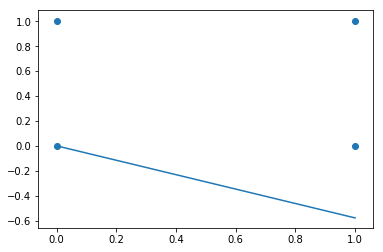


------------ delta ------------
-
dZ1: 
[[ 0.12500715  0.14811148  0.14432945 -0.04463427]]
sig_prime1: 
[[0.25       0.22017345 0.23943261 0.1838414 ]]
dW1: 
[[0.02492379 0.0258693 ]]
db1: 
[[0.09320345]]
--------------------------------

------------ params ------------
-
W1: 
[[0.41452963 0.71773756]]
b1: 
[[-0.00920597]]
--------------------------------
**************************************************


-> Epoca: 00002 - Erro: 0.27923 - Acurácia: 50%

y_hat: (1, 4) 
[[0.49769852 0.67007661 0.59996605 0.7545561 ]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



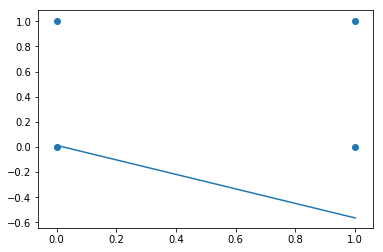


------------ delta ------------
-
dZ1: 
[[ 0.12442199  0.14813648  0.14399593 -0.0454565 ]]
sig_prime1: 
[[0.2499947  0.22107395 0.24000679 0.18520119]]
dW1: 
[[0.02463486 0.02566999]]
db1: 
[[0.09277447]]
--------------------------------

------------ params ------------
-
W1: 
[[0.41206614 0.71517056]]
b1: 
[[-0.01848342]]
--------------------------------
**************************************************


-> Epoca: 00003 - Erro: 0.27726 - Acurácia: 50%

y_hat: (1, 4) 
[[0.49537928 0.66745286 0.59714487 0.75189661]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



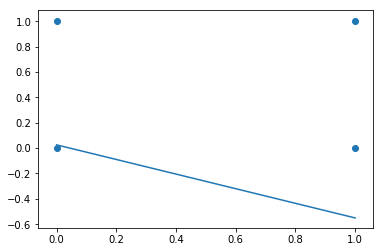


------------ delta ------------
-
dZ1: 
[[ 0.12383424  0.14814753  0.14365089 -0.04628321]]
sig_prime1: 
[[0.24997865 0.22195954 0.24056287 0.1865481 ]]
dW1: 
[[0.02434192 0.02546608]]
db1: 
[[0.09233736]]
--------------------------------

------------ params ------------
-
W1: 
[[0.40963195 0.71262396]]
b1: 
[[-0.02771715]]
--------------------------------
**************************************************


-> Epoca: 00004 - Erro: 0.27531 - Acurácia: 50%

y_hat: (1, 4) 
[[0.49307116 0.66483296 0.59433484 0.74923543]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



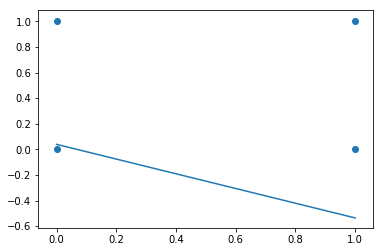


------------ delta ------------
-
dZ1: 
[[ 0.12324412  0.14814479  0.14329469 -0.04711407]]
sig_prime1: 
[[0.24995199 0.22283009 0.24110094 0.1878817 ]]
dW1: 
[[0.02404515 0.02525768]]
db1: 
[[0.09189238]]
--------------------------------

------------ params ------------
-
W1: 
[[0.40722743 0.71009819]]
b1: 
[[-0.03690639]]
--------------------------------
**************************************************


-> Epoca: 00005 - Erro: 0.27338 - Acurácia: 50%

y_hat: (1, 4) 
[[0.49077445 0.66221749 0.59153655 0.74657331]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



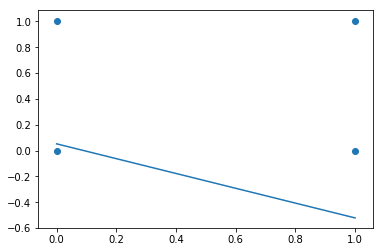


------------ delta ------------
-
dZ1: 
[[ 0.12265184  0.14812844  0.14292769 -0.04794874]]
sig_prime1: 
[[0.24991489 0.22368549 0.24162106 0.1892016 ]]
dW1: 
[[0.02374474 0.02504493]]
db1: 
[[0.09143981]]
--------------------------------

------------ params ------------
-
W1: 
[[0.40485296 0.7075937 ]]
b1: 
[[-0.04605037]]
--------------------------------
**************************************************


-> Epoca: 00006 - Erro: 0.27148 - Acurácia: 50%

y_hat: (1, 4) 
[[0.48848944 0.65960699 0.58875054 0.74391098]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



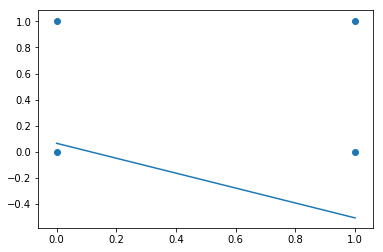


------------ delta ------------
-
dZ1: 
[[ 0.12205764  0.14809866  0.14255025 -0.04878686]]
sig_prime1: 
[[0.24986751 0.22452561 0.24212334 0.19050743]]
dW1: 
[[0.02344085 0.02482795]]
db1: 
[[0.09097992]]
--------------------------------

------------ params ------------
-
W1: 
[[0.40250887 0.7051109 ]]
b1: 
[[-0.05514837]]
--------------------------------
**************************************************


-> Epoca: 00007 - Erro: 0.26959 - Acurácia: 50%

y_hat: (1, 4) 
[[0.4862164  0.65700202 0.58597736 0.7412492 ]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



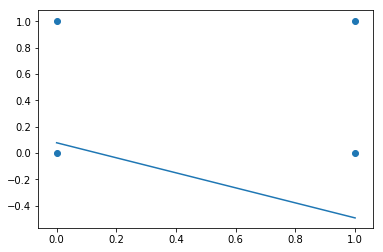


------------ delta ------------
-
dZ1: 
[[ 0.12146173  0.14805565  0.14216273 -0.0496281 ]]
sig_prime1: 
[[0.24981001 0.22535037 0.24260789 0.19179883]]
dW1: 
[[0.02313366 0.02460689]]
db1: 
[[0.090513]]
--------------------------------

------------ params ------------
-
W1: 
[[0.40019551 0.70265021]]
b1: 
[[-0.06419967]]
--------------------------------
**************************************************


-> Epoca: 00008 - Erro: 0.26773 - Acurácia: 50%

y_hat: (1, 4) 
[[0.48395559 0.65440312 0.58321754 0.73858868]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



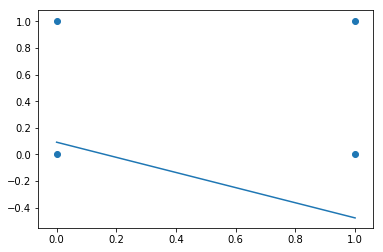


------------ delta ------------
-
dZ1: 
[[ 0.12086432  0.1479996   0.14176551 -0.05047211]]
sig_prime1: 
[[0.24974258 0.22615968 0.24307484 0.19307544]]
dW1: 
[[0.02282335 0.02438187]]
db1: 
[[0.09003933]]
--------------------------------

------------ params ------------
-
W1: 
[[0.39791317 0.70021202]]
b1: 
[[-0.0732036]]
--------------------------------
**************************************************


-> Epoca: 00009 - Erro: 0.26589 - Acurácia: 50%

y_hat: (1, 4) 
[[0.48170727 0.65181082 0.58047158 0.73593016]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



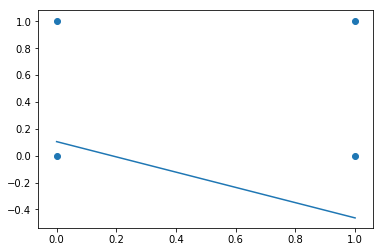


------------ delta ------------
-
dZ1: 
[[ 0.12026563  0.14793073  0.14135895 -0.05131853]]
sig_prime1: 
[[0.24966538 0.22695347 0.24352432 0.19433696]]
dW1: 
[[0.0225101  0.02415305]]
db1: 
[[0.08955919]]
--------------------------------

------------ params ------------
-
W1: 
[[0.39566216 0.69779672]]
b1: 
[[-0.08215952]]
--------------------------------
**************************************************


-> Epoca: 00010 - Erro: 0.26408 - Acurácia: 50%

y_hat: (1, 4) 
[[0.47947167 0.64922565 0.57773999 0.73327436]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



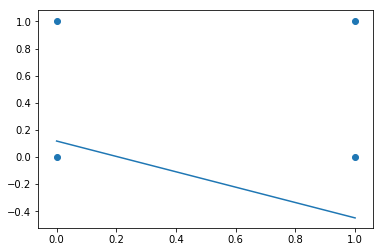


------------ delta ------------
-
dZ1: 
[[ 0.11966586  0.14784926  0.14094342 -0.05216702]]
sig_prime1: 
[[0.24957859 0.22773171 0.24395649 0.19558307]]
dW1: 
[[0.0221941  0.02392056]]
db1: 
[[0.08907288]]
--------------------------------

------------ params ------------
-
W1: 
[[0.39344275 0.69540466]]
b1: 
[[-0.09106681]]
--------------------------------
**************************************************


-> Epoca: 00011 - Erro: 0.26228 - Acurácia: 50%

y_hat: (1, 4) 
[[0.47724902 0.64664811 0.57502323 0.730622  ]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



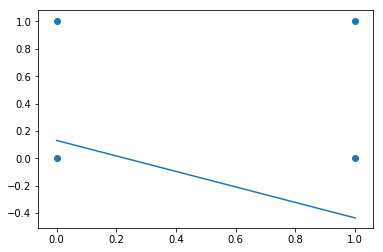


------------ delta ------------
-
dZ1: 
[[ 0.11906523  0.14775543  0.1405193  -0.05301723]]
sig_prime1: 
[[0.24948239 0.22849433 0.24437151 0.19681349]]
dW1: 
[[0.02187552 0.02368455]]
db1: 
[[0.08858068]]
--------------------------------

------------ params ------------
-
W1: 
[[0.3912552  0.69303621]]
b1: 
[[-0.09992487]]
--------------------------------
**************************************************


-> Epoca: 00012 - Erro: 0.26051 - Acurácia: 50%

y_hat: (1, 4) 
[[0.47503955 0.64407871 0.57232179 0.72797377]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



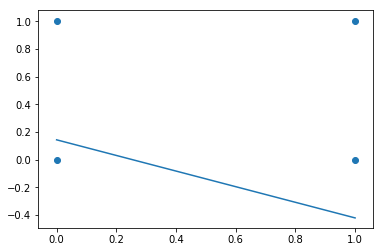


------------ delta ------------
-
dZ1: 
[[ 0.11846393  0.14764946  0.14008695 -0.0538688 ]]
sig_prime1: 
[[0.24937698 0.22924132 0.24476956 0.19802796]]
dW1: 
[[0.02155454 0.02344516]]
db1: 
[[0.08808288]]
--------------------------------

------------ params ------------
-
W1: 
[[0.38909975 0.69069169]]
b1: 
[[-0.10873316]]
--------------------------------
**************************************************


-> Epoca: 00013 - Erro: 0.25876 - Acurácia: 50%

y_hat: (1, 4) 
[[0.47284346 0.64151794 0.56963609 0.72533038]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



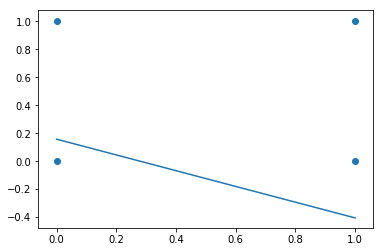


------------ delta ------------
-
dZ1: 
[[ 0.11786215  0.1475316   0.13964675 -0.05472139]]
sig_prime1: 
[[0.24926252 0.22997267 0.24515081 0.19922622]]
dW1: 
[[0.02123134 0.02320255]]
db1: 
[[0.08757978]]
--------------------------------

------------ params ------------
-
W1: 
[[0.38697661 0.68837144]]
b1: 
[[-0.11749114]]
--------------------------------
**************************************************


-> Epoca: 00014 - Erro: 0.25704 - Acurácia: 50%

y_hat: (1, 4) 
[[0.47066096 0.63896627 0.56696658 0.72269252]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



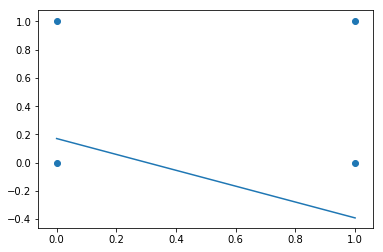


------------ delta ------------
-
dZ1: 
[[ 0.1172601   0.14740209  0.13919907 -0.05557465]]
sig_prime1: 
[[0.24913922 0.23068837 0.24551548 0.20040804]]
dW1: 
[[0.02090611 0.02295686]]
db1: 
[[0.08707165]]
--------------------------------

------------ params ------------
-
W1: 
[[0.384886   0.68607575]]
b1: 
[[-0.12619831]]
--------------------------------
**************************************************


-> Epoca: 00015 - Erro: 0.25533 - Acurácia: 50%

y_hat: (1, 4) 
[[0.46849223 0.63642418 0.56431367 0.72006085]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



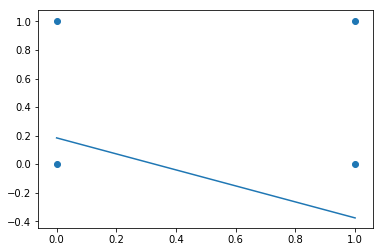


------------ delta ------------
-
dZ1: 
[[ 0.11665797  0.1472612   0.13874428 -0.05642824]]
sig_prime1: 
[[0.24900726 0.23138844 0.24586375 0.20157322]]
dW1: 
[[0.02057901 0.02270824]]
db1: 
[[0.0865588]]
--------------------------------

------------ params ------------
-
W1: 
[[0.3828281  0.68380493]]
b1: 
[[-0.13485419]]
--------------------------------
**************************************************


-> Epoca: 00016 - Erro: 0.25365 - Acurácia: 50%

y_hat: (1, 4) 
[[0.46633745 0.63389212 0.56167775 0.71743603]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



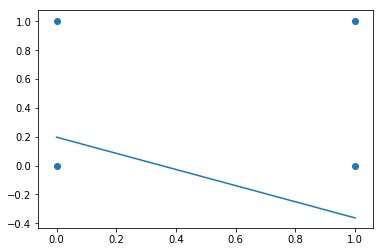


------------ delta ------------
-
dZ1: 
[[ 0.11605592  0.14710918  0.13828273 -0.05728181]]
sig_prime1: 
[[0.24886683 0.2320729  0.24619586 0.20272157]]
dW1: 
[[0.02025023 0.02245684]]
db1: 
[[0.08604151]]
--------------------------------

------------ params ------------
-
W1: 
[[0.38080308 0.68155924]]
b1: 
[[-0.14345834]]
--------------------------------
**************************************************


-> Epoca: 00017 - Erro: 0.25200 - Acurácia: 50%

y_hat: (1, 4) 
[[0.4641968  0.63137053 0.5590592  0.71481873]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



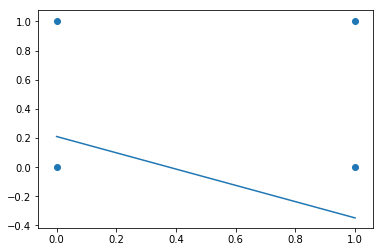


------------ delta ------------
-
dZ1: 
[[ 0.11545416  0.1469463   0.13781481 -0.05813503]]
sig_prime1: 
[[0.24871813 0.23274178 0.24651201 0.20385291]]
dW1: 
[[0.01991994 0.02220282]]
db1: 
[[0.08552006]]
--------------------------------

------------ params ------------
-
W1: 
[[0.37881108 0.67933896]]
b1: 
[[-0.15201034]]
--------------------------------
**************************************************


-> Epoca: 00018 - Erro: 0.25036 - Acurácia: 50%

y_hat: (1, 4) 
[[0.46207042 0.62885984 0.55645838 0.71220958]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



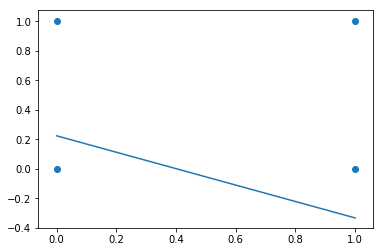


------------ delta ------------
-
dZ1: 
[[ 0.11485285  0.14677283  0.13734086 -0.05898757]]
sig_prime1: 
[[0.24856135 0.23339514 0.24681245 0.2049671 ]]
dW1: 
[[0.01958832 0.02194632]]
db1: 
[[0.08499474]]
--------------------------------

------------ params ------------
-
W1: 
[[0.37685225 0.67714433]]
b1: 
[[-0.16050982]]
--------------------------------
**************************************************


-> Epoca: 00019 - Erro: 0.24875 - Acurácia: 50%

y_hat: (1, 4) 
[[0.45995848 0.62636047 0.55387564 0.70960919]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



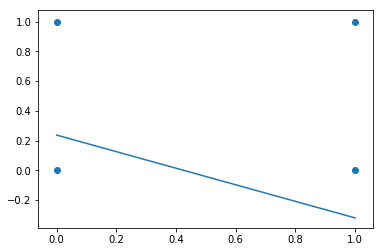


------------ delta ------------
-
dZ1: 
[[ 0.11425216  0.14658904  0.13686124 -0.05983909]]
sig_prime1: 
[[0.24839668 0.23403303 0.24709742 0.20606399]]
dW1: 
[[0.01925554 0.02168749]]
db1: 
[[0.08446584]]
--------------------------------

------------ params ------------
-
W1: 
[[0.3749267  0.67497558]]
b1: 
[[-0.1689564]]
--------------------------------
**************************************************


-> Epoca: 00020 - Erro: 0.24716 - Acurácia: 50%

y_hat: (1, 4) 
[[0.45786109 0.62387281 0.5513113  0.70701819]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



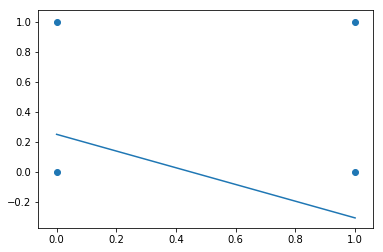


------------ delta ------------
-
dZ1: 
[[ 0.11365226  0.1463952   0.13637631 -0.06068927]]
sig_prime1: 
[[0.24822431 0.23465553 0.24736715 0.20714347]]
dW1: 
[[0.01892176 0.02142648]]
db1: 
[[0.08393362]]
--------------------------------

------------ params ------------
-
W1: 
[[0.37303452 0.67283293]]
b1: 
[[-0.17734976]]
--------------------------------
**************************************************


-> Epoca: 00021 - Erro: 0.24559 - Acurácia: 50%

y_hat: (1, 4) 
[[0.45577841 0.62139727 0.54876568 0.70443717]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



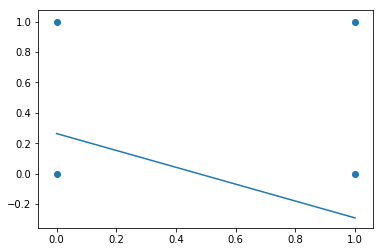


------------ delta ------------
-
dZ1: 
[[ 0.1130533   0.1461916   0.1358864  -0.06153779]]
sig_prime1: 
[[0.24804445 0.2352627  0.24762191 0.20820544]]
dW1: 
[[0.01858715 0.02116345]]
db1: 
[[0.08339838]]
--------------------------------

------------ params ------------
-
W1: 
[[0.37117581 0.67071659]]
b1: 
[[-0.1856896]]
--------------------------------
**************************************************


-> Epoca: 00022 - Erro: 0.24405 - Acurácia: 50%

y_hat: (1, 4) 
[[0.45371053 0.61893422 0.54623906 0.7018667 ]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



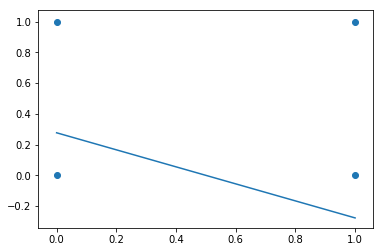


------------ delta ------------
-
dZ1: 
[[ 0.11245546  0.14597851  0.13539188 -0.06238434]]
sig_prime1: 
[[0.24785729 0.23585465 0.24786195 0.20924984]]
dW1: 
[[0.01825188 0.02089854]]
db1: 
[[0.08286038]]
--------------------------------

------------ params ------------
-
W1: 
[[0.36935062 0.66862673]]
b1: 
[[-0.19397564]]
--------------------------------
**************************************************


-> Epoca: 00023 - Erro: 0.24253 - Acurácia: 50%

y_hat: (1, 4) 
[[0.45165758 0.61648402 0.54373172 0.69930735]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



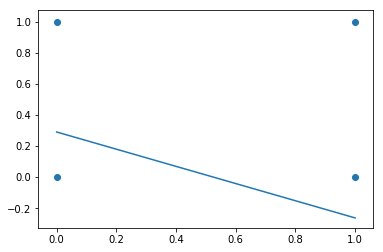


------------ delta ------------
-
dZ1: 
[[ 0.11185887  0.14575622  0.13489306 -0.06322862]]
sig_prime1: 
[[0.24766301 0.23643147 0.24808754 0.21027658]]
dW1: 
[[0.01791611 0.0206319 ]]
db1: 
[[0.08231989]]
--------------------------------

------------ params ------------
-
W1: 
[[0.36755901 0.66656354]]
b1: 
[[-0.20220763]]
--------------------------------
**************************************************


-> Epoca: 00024 - Erro: 0.24103 - Acurácia: 50%

y_hat: (1, 4) 
[[0.44961964 0.61404701 0.54124392 0.69675968]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



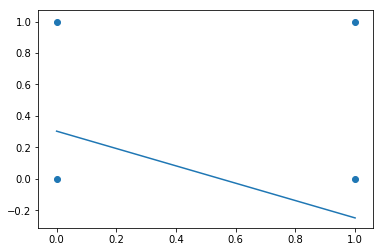


------------ delta ------------
-
dZ1: 
[[ 0.11126369  0.14552501  0.13439029 -0.06407032]]
sig_prime1: 
[[0.24746182 0.23699328 0.24829894 0.21128563]]
dW1: 
[[0.01757999 0.02036367]]
db1: 
[[0.08177717]]
--------------------------------

------------ params ------------
-
W1: 
[[0.36580101 0.66452717]]
b1: 
[[-0.21038534]]
--------------------------------
**************************************************


-> Epoca: 00025 - Erro: 0.23955 - Acurácia: 50%

y_hat: (1, 4) 
[[0.44759681 0.61162354 0.5387759  0.69422421]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



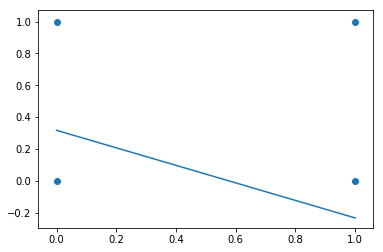


------------ delta ------------
-
dZ1: 
[[ 0.11067006  0.14528517  0.13388389 -0.06490916]]
sig_prime1: 
[[0.24725391 0.23754019 0.24849643 0.21227696]]
dW1: 
[[0.01724368 0.020094  ]]
db1: 
[[0.08123249]]
--------------------------------

------------ params ------------
-
W1: 
[[0.36407664 0.66251777]]
b1: 
[[-0.21850859]]
--------------------------------
**************************************************


-> Epoca: 00026 - Erro: 0.23810 - Acurácia: 50%

y_hat: (1, 4) 
[[0.44558917 0.60921392 0.53632789 0.69170145]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



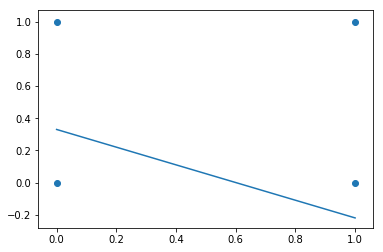


------------ delta ------------
-
dZ1: 
[[ 0.11007811  0.14503697  0.13337417 -0.06574484]]
sig_prime1: 
[[0.24703946 0.23807232 0.24868028 0.21325055]]
dW1: 
[[0.01690733 0.01982303]]
db1: 
[[0.0806861]]
--------------------------------

------------ params ------------
-
W1: 
[[0.36238591 0.66053547]]
b1: 
[[-0.2265772]]
--------------------------------
**************************************************


-> Epoca: 00027 - Erro: 0.23666 - Acurácia: 50%

y_hat: (1, 4) 
[[0.44359679 0.60681847 0.53390009 0.68919192]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



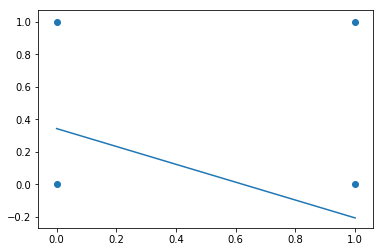


------------ delta ------------
-
dZ1: 
[[ 0.10948797  0.14478071  0.13286146 -0.06657708]]
sig_prime1: 
[[0.24681868 0.23858981 0.24885078 0.21420642]]
dW1: 
[[0.01657109 0.01955091]]
db1: 
[[0.08013826]]
--------------------------------

------------ params ------------
-
W1: 
[[0.3607288  0.65858038]]
b1: 
[[-0.23459103]]
--------------------------------
**************************************************


-> Epoca: 00028 - Erro: 0.23525 - Acurácia: 50%

y_hat: (1, 4) 
[[0.44161973 0.60443747 0.5314927  0.68669609]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



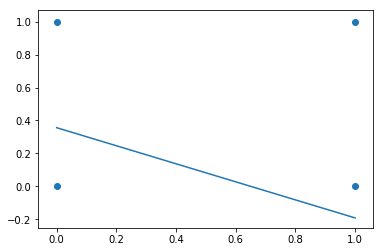


------------ delta ------------
-
dZ1: 
[[ 0.10889978  0.14451666  0.13234605 -0.06740563]]
sig_prime1: 
[[0.24659174 0.23909281 0.24900821 0.21514457]]
dW1: 
[[0.0162351  0.01927776]]
db1: 
[[0.07958921]]
--------------------------------

------------ params ------------
-
W1: 
[[0.35910529 0.6566526 ]]
b1: 
[[-0.24254995]]
--------------------------------
**************************************************


-> Epoca: 00029 - Erro: 0.23387 - Acurácia: 50%

y_hat: (1, 4) 
[[0.43965805 0.60207121 0.52910589 0.68421443]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



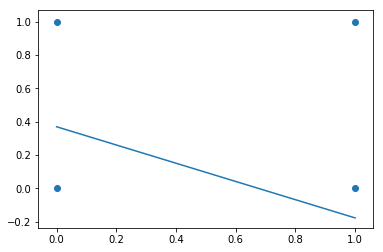


------------ delta ------------
-
dZ1: 
[[ 0.10831365  0.1442451   0.13182824 -0.06823022]]
sig_prime1: 
[[0.24635885 0.23958147 0.24915285 0.21606504]]
dW1: 
[[0.0158995  0.01900372]]
db1: 
[[0.07903919]]
--------------------------------

------------ params ------------
-
W1: 
[[0.35751534 0.65475223]]
b1: 
[[-0.25045387]]
--------------------------------
**************************************************


-> Epoca: 00030 - Erro: 0.23250 - Acurácia: 50%

y_hat: (1, 4) 
[[0.43771179 0.59971995 0.52673983 0.68174738]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



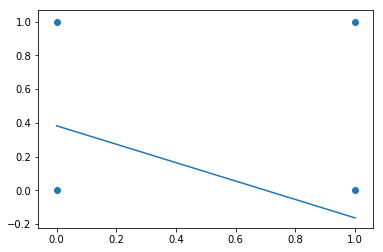


------------ delta ------------
-
dZ1: 
[[ 0.1077297   0.14396633  0.13130833 -0.0690506 ]]
sig_prime1: 
[[0.24612018 0.24005593 0.24928498 0.21696789]]
dW1: 
[[0.01556443 0.01872893]]
db1: 
[[0.07848844]]
--------------------------------

------------ params ------------
-
W1: 
[[0.35595889 0.65287934]]
b1: 
[[-0.25830271]]
--------------------------------
**************************************************


-> Epoca: 00031 - Erro: 0.23115 - Acurácia: 50%

y_hat: (1, 4) 
[[0.43578098 0.59738394 0.52439466 0.67929537]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



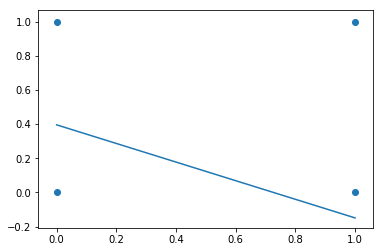


------------ delta ------------
-
dZ1: 
[[ 0.10714805  0.14368062  0.1307866  -0.06986652]]
sig_prime1: 
[[0.24587592 0.24051637 0.2494049  0.21785317]]
dW1: 
[[0.01523002 0.01845352]]
db1: 
[[0.07793719]]
--------------------------------

------------ params ------------
-
W1: 
[[0.35443589 0.65103399]]
b1: 
[[-0.26609643]]
--------------------------------
**************************************************


-> Epoca: 00032 - Erro: 0.22983 - Acurácia: 50%

y_hat: (1, 4) 
[[0.43386566 0.59506343 0.52207051 0.67685883]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



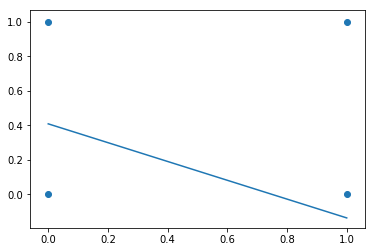


------------ delta ------------
-
dZ1: 
[[ 0.1065688   0.14338824  0.13026332 -0.07067774]]
sig_prime1: 
[[0.24562625 0.24096294 0.24951289 0.21872095]]
dW1: 
[[0.01489639 0.01817762]]
db1: 
[[0.07738565]]
--------------------------------

------------ params ------------
-
W1: 
[[0.35294625 0.64921622]]
b1: 
[[-0.273835]]
--------------------------------
**************************************************


-> Epoca: 00033 - Erro: 0.22853 - Acurácia: 50%

y_hat: (1, 4) 
[[0.43196585 0.59275863 0.5197675  0.67443814]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



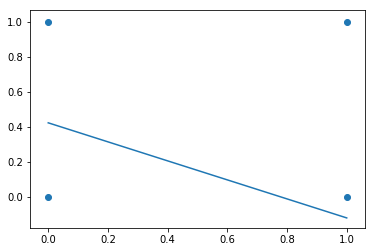


------------ delta ------------
-
dZ1: 
[[ 0.10599205  0.14308947  0.12973877 -0.07148405]]
sig_prime1: 
[[0.24537135 0.24139584 0.24960925 0.21957133]]
dW1: 
[[0.01456368 0.01790135]]
db1: 
[[0.07683406]]
--------------------------------

------------ params ------------
-
W1: 
[[0.35148988 0.64742609]]
b1: 
[[-0.2815184]]
--------------------------------
**************************************************


-> Epoca: 00034 - Erro: 0.22724 - Acurácia: 50%

y_hat: (1, 4) 
[[0.43008156 0.59046976 0.51748574 0.67203369]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



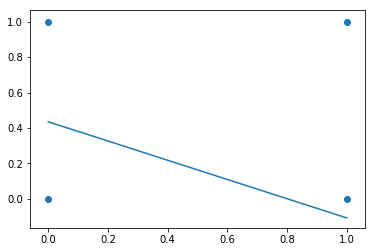


------------ delta ------------
-
dZ1: 
[[ 0.1054179   0.14278458  0.12921321 -0.07228522]]
sig_prime1: 
[[0.24511141 0.24181522 0.24969425 0.22040441]]
dW1: 
[[0.014232   0.01762484]]
db1: 
[[0.07628262]]
--------------------------------

------------ params ------------
-
W1: 
[[0.35006668 0.64566361]]
b1: 
[[-0.28914667]]
--------------------------------
**************************************************


-> Epoca: 00035 - Erro: 0.22598 - Acurácia: 50%

y_hat: (1, 4) 
[[0.42821279 0.58819702 0.5152253  0.66964583]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



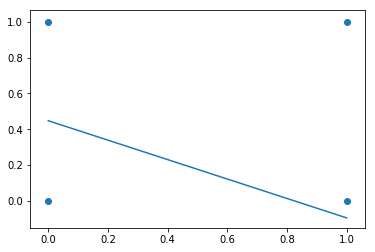


------------ delta ------------
-
dZ1: 
[[ 0.10484644  0.14247384  0.12868689 -0.07308105]]
sig_prime1: 
[[0.2448466  0.24222129 0.24976819 0.22122029]]
dW1: 
[[0.01390146 0.0173482 ]]
db1: 
[[0.07573153]]
--------------------------------

------------ params ------------
-
W1: 
[[0.34867654 0.64392879]]
b1: 
[[-0.29671982]]
--------------------------------
**************************************************


-> Epoca: 00036 - Erro: 0.22474 - Acurácia: 50%

y_hat: (1, 4) 
[[0.42635955 0.5859406  0.51298626 0.66727491]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



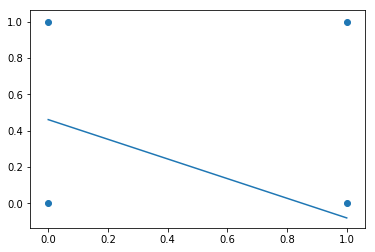


------------ delta ------------
-
dZ1: 
[[ 0.10427777  0.14215752  0.12816005 -0.07387133]]
sig_prime1: 
[[0.24457708 0.24261421 0.24983136 0.22201911]]
dW1: 
[[0.01357218 0.01707155]]
db1: 
[[0.075181]]
--------------------------------

------------ params ------------
-
W1: 
[[0.34731932 0.64222163]]
b1: 
[[-0.30423792]]
--------------------------------
**************************************************


-> Epoca: 00037 - Erro: 0.22352 - Acurácia: 50%

y_hat: (1, 4) 
[[0.42452182 0.58370066 0.51076868 0.66492125]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



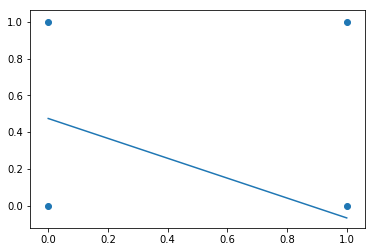


------------ delta ------------
-
dZ1: 
[[ 0.10371197  0.14183587  0.12763294 -0.07465587]]
sig_prime1: 
[[0.24430304 0.2429942  0.24988404 0.22280098]]
dW1: 
[[0.01324427 0.016795  ]]
db1: 
[[0.07463123]]
--------------------------------

------------ params ------------
-
W1: 
[[0.34599489 0.64054213]]
b1: 
[[-0.31170104]]
--------------------------------
**************************************************


-> Epoca: 00038 - Erro: 0.22232 - Acurácia: 50%

y_hat: (1, 4) 
[[0.42269959 0.58147737 0.50857262 0.66258517]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



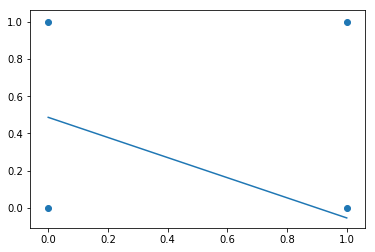


------------ delta ------------
-
dZ1: 
[[ 0.10314912  0.14150917  0.12710578 -0.07543451]]
sig_prime1: 
[[0.24402465 0.24336144 0.24992651 0.22356606]]
dW1: 
[[0.01291782 0.01651867]]
db1: 
[[0.07408239]]
--------------------------------

------------ params ------------
-
W1: 
[[0.34470311 0.63889026]]
b1: 
[[-0.31910928]]
--------------------------------
**************************************************


-> Epoca: 00039 - Erro: 0.22114 - Acurácia: 50%

y_hat: (1, 4) 
[[0.42089284 0.57927088 0.50639811 0.66026696]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



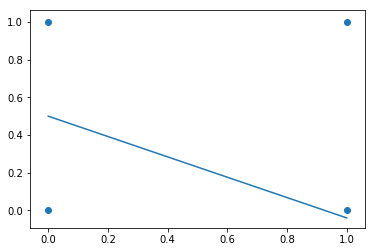


------------ delta ------------
-
dZ1: 
[[ 0.10258929  0.14117765  0.1265788  -0.07620705]]
sig_prime1: 
[[0.24374206 0.24371613 0.24995906 0.2243145 ]]
dW1: 
[[0.01259294 0.01624265]]
db1: 
[[0.07353467]]
--------------------------------

------------ params ------------
-
W1: 
[[0.34344382 0.637266  ]]
b1: 
[[-0.32646275]]
--------------------------------
**************************************************


-> Epoca: 00040 - Erro: 0.21998 - Acurácia: 50%

y_hat: (1, 4) 
[[0.41910154 0.57708131 0.50424517 0.65796689]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



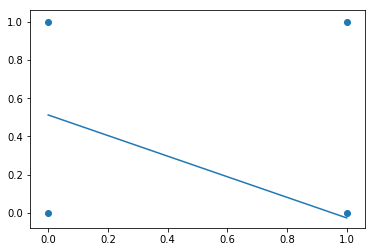


------------ delta ------------
-
dZ1: 
[[ 0.10203255  0.14084158  0.1260522  -0.07697334]]
sig_prime1: 
[[0.24345544 0.24405847 0.24998198 0.22504646]]
dW1: 
[[0.01226972 0.01596706]]
db1: 
[[0.07298825]]
--------------------------------

------------ params ------------
-
W1: 
[[0.34221685 0.63566929]]
b1: 
[[-0.33376157]]
--------------------------------
**************************************************


-> Epoca: 00041 - Erro: 0.21884 - Acurácia: 50%

y_hat: (1, 4) 
[[0.41732566 0.57490881 0.50211381 0.65568523]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



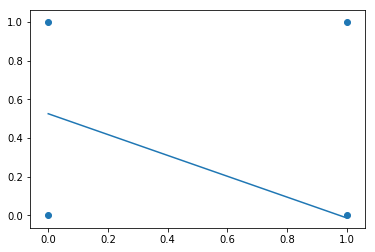


------------ delta ------------
-
dZ1: 
[[ 0.10147897  0.1405012   0.12552621 -0.07773323]]
sig_prime1: 
[[0.24316495 0.24438867 0.24999553 0.22576211]]
dW1: 
[[0.01194824 0.01569199]]
db1: 
[[0.07244329]]
--------------------------------

------------ params ------------
-
W1: 
[[0.34102202 0.63410009]]
b1: 
[[-0.3410059]]
--------------------------------
**************************************************


-> Epoca: 00042 - Erro: 0.21772 - Acurácia: 50%

y_hat: (1, 4) 
[[0.41556515 0.57275347 0.50000403 0.65342221]] --> [[0. 1. 1. 1.]]
                                                    [[0 0 0 1]]



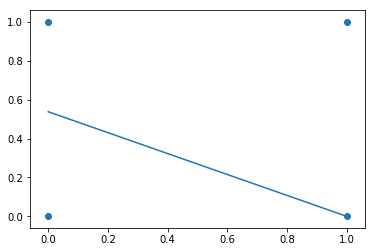


------------ delta ------------
-
dZ1: 
[[ 0.10092862  0.14015675  0.12500101 -0.07848657]]
sig_prime1: 
[[0.24287076 0.24470693 0.25       0.22646162]]
dW1: 
[[0.01162861 0.01541754]]
db1: 
[[0.07189995]]
--------------------------------

------------ params ------------
-
W1: 
[[0.33985916 0.63255834]]
b1: 
[[-0.3481959]]
--------------------------------
**************************************************


-> Epoca: 00043 - Erro: 0.21661 - Acurácia: 75%

y_hat: (1, 4) 
[[0.41381998 0.57061541 0.49791583 0.65117808]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



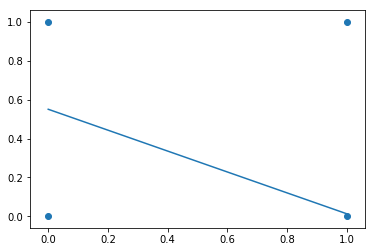


------------ delta ------------
-
dZ1: 
[[ 0.10038156  0.13980846  0.12447679 -0.07923322]]
sig_prime1: 
[[0.242573   0.24501346 0.24999566 0.22714519]]
dW1: 
[[0.01131089 0.01514381]]
db1: 
[[0.0713584]]
--------------------------------

------------ params ------------
-
W1: 
[[0.33872807 0.63104396]]
b1: 
[[-0.35533174]]
--------------------------------
**************************************************


-> Epoca: 00044 - Erro: 0.21553 - Acurácia: 75%

y_hat: (1, 4) 
[[0.41209009 0.56849471 0.49584918 0.64895303]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



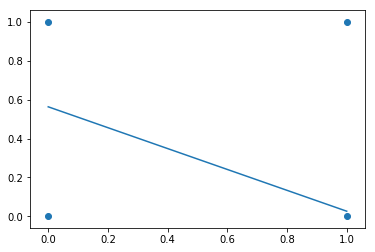


------------ delta ------------
-
dZ1: 
[[ 0.09983783  0.13945657  0.12395375 -0.07997306]]
sig_prime1: 
[[0.24227185 0.24530848 0.24998277 0.227813  ]]
dW1: 
[[0.01099517 0.01487088]]
db1: 
[[0.07081877]]
--------------------------------

------------ params ------------
-
W1: 
[[0.33762855 0.62955687]]
b1: 
[[-0.36241361]]
--------------------------------
**************************************************


-> Epoca: 00045 - Erro: 0.21446 - Acurácia: 75%

y_hat: (1, 4) 
[[0.41037542 0.56639144 0.49380405 0.64674726]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



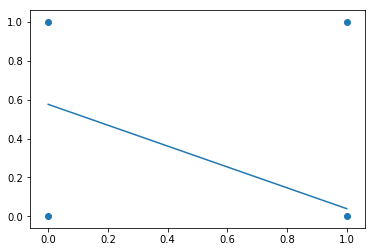


------------ delta ------------
-
dZ1: 
[[ 0.09929749  0.13910131  0.12343206 -0.08070597]]
sig_prime1: 
[[0.24196744 0.24559218 0.24996161 0.22846524]]
dW1: 
[[0.01068152 0.01459883]]
db1: 
[[0.07028122]]
--------------------------------

------------ params ------------
-
W1: 
[[0.3365604  0.62809699]]
b1: 
[[-0.36944174]]
--------------------------------
**************************************************


-> Epoca: 00046 - Erro: 0.21341 - Acurácia: 75%

y_hat: (1, 4) 
[[0.40867592 0.56430569 0.49178041 0.64456096]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



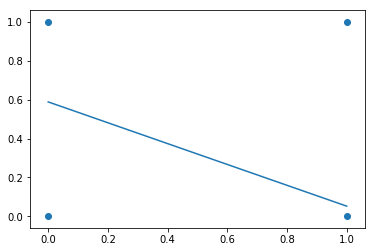


------------ delta ------------
-
dZ1: 
[[ 0.09876059  0.13874289  0.12291188 -0.08143184]]
sig_prime1: 
[[0.24165991 0.24586478 0.24993244 0.22910213]]
dW1: 
[[0.01037001 0.01432776]]
db1: 
[[0.06974588]]
--------------------------------

------------ params ------------
-
W1: 
[[0.3355234  0.62666421]]
b1: 
[[-0.37641632]]
--------------------------------
**************************************************


-> Epoca: 00047 - Erro: 0.21238 - Acurácia: 75%

y_hat: (1, 4) 
[[0.40699153 0.56223751 0.48977819 0.6423943 ]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



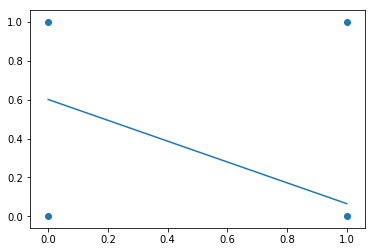


------------ delta ------------
-
dZ1: 
[[ 0.09822717  0.13838155  0.12239337 -0.08215056]]
sig_prime1: 
[[0.24134942 0.24612649 0.24989551 0.22972386]]
dW1: 
[[0.0100607  0.01405775]]
db1: 
[[0.06921288]]
--------------------------------

------------ params ------------
-
W1: 
[[0.33451733 0.62525844]]
b1: 
[[-0.38333761]]
--------------------------------
**************************************************


-> Epoca: 00048 - Erro: 0.21137 - Acurácia: 75%

y_hat: (1, 4) 
[[0.40532216 0.56018695 0.48779735 0.64024741]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



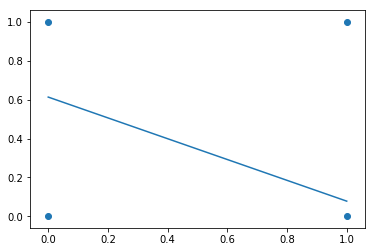


------------ delta ------------
-
dZ1: 
[[ 0.09769727  0.13801748  0.1218767  -0.08286205]]
sig_prime1: 
[[0.24103611 0.24637753 0.2498511  0.23033066]]
dW1: 
[[0.00975366 0.01378886]]
db1: 
[[0.06868235]]
--------------------------------

------------ params ------------
-
W1: 
[[0.33354196 0.62387955]]
b1: 
[[-0.39020585]]
--------------------------------
**************************************************


-> Epoca: 00049 - Erro: 0.21037 - Acurácia: 75%

y_hat: (1, 4) 
[[0.40366775 0.55815405 0.48583782 0.63812046]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



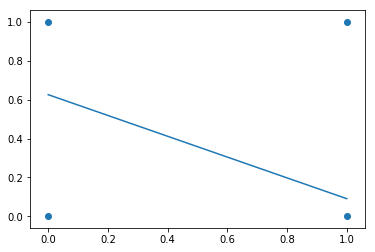


------------ delta ------------
-
dZ1: 
[[ 0.09717094  0.13765089  0.12136201 -0.08356622]]
sig_prime1: 
[[0.2407201  0.24661811 0.24979943 0.23092274]]
dW1: 
[[0.00944895 0.01352117]]
db1: 
[[0.06815441]]
--------------------------------

------------ params ------------
-
W1: 
[[0.33259707 0.62252743]]
b1: 
[[-0.39702129]]
--------------------------------
**************************************************


-> Epoca: 00050 - Erro: 0.20939 - Acurácia: 75%

y_hat: (1, 4) 
[[0.40202822 0.55613884 0.48389951 0.63601355]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



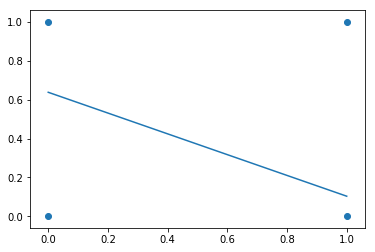


------------ delta ------------
-
dZ1: 
[[ 0.0966482   0.137282    0.12084944 -0.08426298]]
sig_prime1: 
[[0.24040153 0.24684843 0.24974077 0.23150031]]
dW1: 
[[0.00914662 0.01325476]]
db1: 
[[0.06762916]]
--------------------------------

------------ params ------------
-
W1: 
[[0.33168241 0.62120196]]
b1: 
[[-0.4037842]]
--------------------------------
**************************************************


-> Epoca: 00051 - Erro: 0.20843 - Acurácia: 75%

y_hat: (1, 4) 
[[0.40040348 0.55414133 0.48198236 0.6339268 ]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



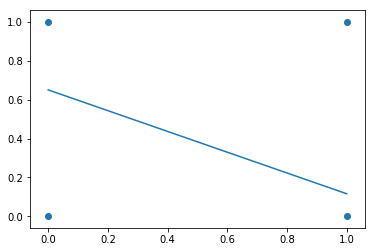


------------ delta ------------
-
dZ1: 
[[ 0.09612908  0.13691099  0.12033912 -0.08495227]]
sig_prime1: 
[[0.24008053 0.24706872 0.24967536 0.23206361]]
dW1: 
[[0.00884671 0.01298968]]
db1: 
[[0.06710673]]
--------------------------------

------------ params ------------
-
W1: 
[[0.33079774 0.61990299]]
b1: 
[[-0.41049488]]
--------------------------------
**************************************************


-> Epoca: 00052 - Erro: 0.20748 - Acurácia: 75%

y_hat: (1, 4) 
[[0.39879346 0.55216155 0.48008625 0.6318603 ]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



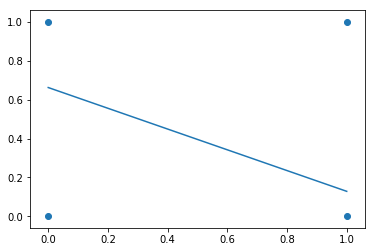


------------ delta ------------
-
dZ1: 
[[ 0.09561362  0.13653805  0.11983118 -0.08563403]]
sig_prime1: 
[[0.23975724 0.24727917 0.24960344 0.23261286]]
dW1: 
[[0.00854929 0.01272601]]
db1: 
[[0.06658721]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32994281 0.61863039]]
b1: 
[[-0.4171536]]
--------------------------------
**************************************************


-> Epoca: 00053 - Erro: 0.20655 - Acurácia: 75%

y_hat: (1, 4) 
[[0.39719807 0.5501995  0.47821111 0.62981415]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



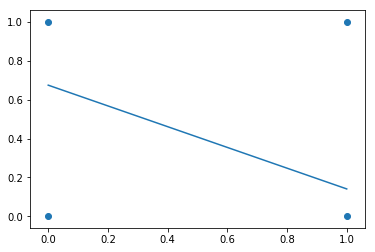


------------ delta ------------
-
dZ1: 
[[ 0.09510183  0.13616338  0.11932574 -0.0863082 ]]
sig_prime1: 
[[0.23943176 0.24748001 0.24952524 0.23314829]]
dW1: 
[[0.00825439 0.0124638 ]]
db1: 
[[0.06607069]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32911737 0.61738401]]
b1: 
[[-0.42376067]]
--------------------------------
**************************************************


-> Epoca: 00054 - Erro: 0.20564 - Acurácia: 75%

y_hat: (1, 4) 
[[0.39561721 0.54825517 0.47635682 0.62778841]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



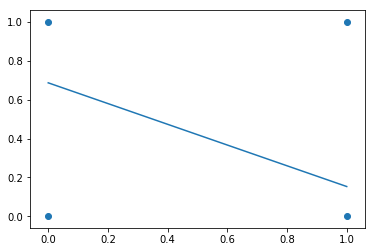


------------ delta ------------
-
dZ1: 
[[ 0.09459375  0.13578715  0.11882292 -0.08697473]]
sig_prime1: 
[[0.23910423 0.24767144 0.249441   0.23367012]]
dW1: 
[[0.00796205 0.01220311]]
db1: 
[[0.06555727]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32832116 0.6161637 ]]
b1: 
[[-0.43031639]]
--------------------------------
**************************************************


-> Epoca: 00055 - Erro: 0.20474 - Acurácia: 75%

y_hat: (1, 4) 
[[0.39405078 0.54632856 0.47452327 0.62578315]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



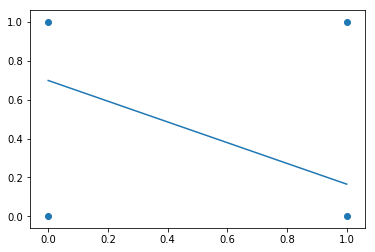


------------ delta ------------
-
dZ1: 
[[ 0.09408938  0.13540954  0.11832282 -0.08763358]]
sig_prime1: 
[[0.23877476 0.24785366 0.24935094 0.2341786 ]]
dW1: 
[[0.00767231 0.01194399]]
db1: 
[[0.06504704]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32755393 0.6149693 ]]
b1: 
[[-0.4368211]]
--------------------------------
**************************************************


-> Epoca: 00056 - Erro: 0.20386 - Acurácia: 75%

y_hat: (1, 4) 
[[0.3924987  0.54441963 0.47271035 0.62379842]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



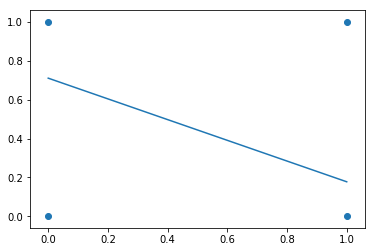


------------ delta ------------
-
dZ1: 
[[ 0.09358875  0.13503071  0.11782555 -0.08828471]]
sig_prime1: 
[[0.23844347 0.2480269  0.24925528 0.23467395]]
dW1: 
[[0.00738521 0.0116865 ]]
db1: 
[[0.06454008]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32681541 0.61380065]]
b1: 
[[-0.44327511]]
--------------------------------
**************************************************


-> Epoca: 00057 - Erro: 0.20299 - Acurácia: 75%

y_hat: (1, 4) 
[[0.39096085 0.54252838 0.47091794 0.62183424]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



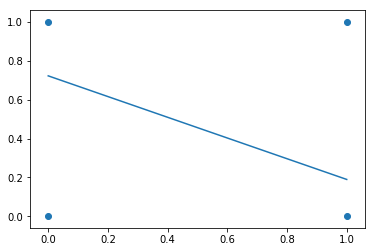


------------ delta ------------
-
dZ1: 
[[ 0.09309187  0.13465084  0.1173312  -0.0889281 ]]
sig_prime1: 
[[0.23811046 0.24819134 0.24915423 0.23515642]]
dW1: 
[[0.00710077 0.01143068]]
db1: 
[[0.06403645]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32610533 0.61265758]]
b1: 
[[-0.44967875]]
--------------------------------
**************************************************


-> Epoca: 00058 - Erro: 0.20214 - Acurácia: 75%

y_hat: (1, 4) 
[[0.38943715 0.54065476 0.4691459  0.61989066]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



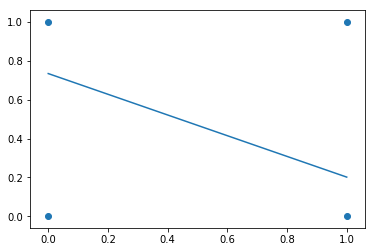


------------ delta ------------
-
dZ1: 
[[ 0.09259875  0.13427009  0.11683986 -0.08956373]]
sig_prime1: 
[[0.23777586 0.24834719 0.24904802 0.23562623]]
dW1: 
[[0.00681903 0.01117659]]
db1: 
[[0.06353624]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32542343 0.61153992]]
b1: 
[[-0.45603238]]
--------------------------------
**************************************************


-> Epoca: 00059 - Erro: 0.20130 - Acurácia: 75%

y_hat: (1, 4) 
[[0.38792748 0.53879873 0.4673941  0.61796769]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



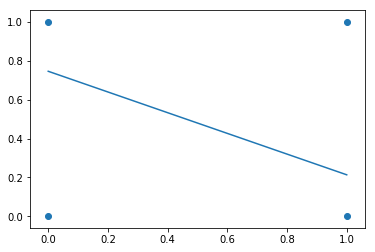


------------ delta ------------
-
dZ1: 
[[ 0.0921094   0.13388861  0.11635162 -0.09019157]]
sig_prime1: 
[[0.23743975 0.24849466 0.24893686 0.23608362]]
dW1: 
[[0.00654001 0.01092426]]
db1: 
[[0.06303951]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32476943 0.6104475 ]]
b1: 
[[-0.46233633]]
--------------------------------
**************************************************


-> Epoca: 00060 - Erro: 0.20048 - Acurácia: 75%

y_hat: (1, 4) 
[[0.38643173 0.53696025 0.46566241 0.61606533]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



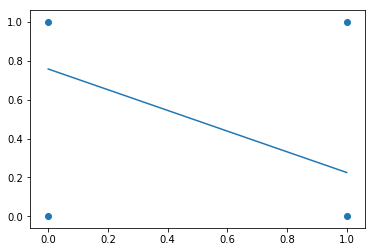


------------ delta ------------
-
dZ1: 
[[ 0.09162383  0.13350654  0.11586655 -0.09081162]]
sig_prime1: 
[[0.23710225 0.24863394 0.24882093 0.23652884]]
dW1: 
[[0.00626373 0.01067373]]
db1: 
[[0.06254633]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32414306 0.60938012]]
b1: 
[[-0.46859096]]
--------------------------------
**************************************************


-> Epoca: 00061 - Erro: 0.19967 - Acurácia: 75%

y_hat: (1, 4) 
[[0.3849498  0.53513927 0.46395068 0.61418358]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



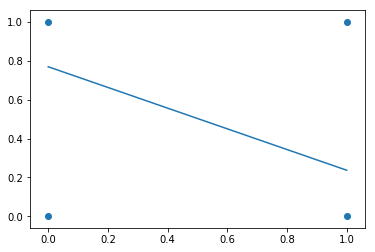


------------ delta ------------
-
dZ1: 
[[ 0.09114204  0.13312404  0.11538474 -0.09142387]]
sig_prime1: 
[[0.23676345 0.24876523 0.24870045 0.23696211]]
dW1: 
[[0.00599022 0.01042504]]
db1: 
[[0.06205674]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32354404 0.60833762]]
b1: 
[[-0.47479663]]
--------------------------------
**************************************************


-> Epoca: 00062 - Erro: 0.19887 - Acurácia: 75%

y_hat: (1, 4) 
[[0.38348158 0.53333572 0.46225877 0.61232244]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



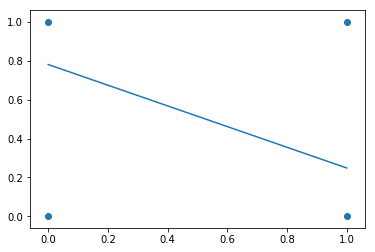


------------ delta ------------
-
dZ1: 
[[ 0.09066404  0.13274125  0.11490625 -0.09202832]]
sig_prime1: 
[[0.23642346 0.24888873 0.2485756  0.23738367]]
dW1: 
[[0.00571948 0.01017823]]
db1: 
[[0.0615708]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32297209 0.6073198 ]]
b1: 
[[-0.48095371]]
--------------------------------
**************************************************


-> Epoca: 00063 - Erro: 0.19809 - Acurácia: 75%

y_hat: (1, 4) 
[[0.38202694 0.53154955 0.46058653 0.61048187]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



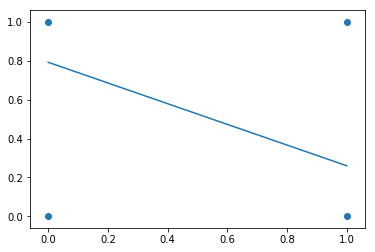


------------ delta ------------
-
dZ1: 
[[ 0.09018982  0.1323583   0.11443115 -0.09262498]]
sig_prime1: 
[[0.23608236 0.24900463 0.24844658 0.23779376]]
dW1: 
[[0.00545154 0.00993333]]
db1: 
[[0.06108857]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32242693 0.60632646]]
b1: 
[[-0.48706257]]
--------------------------------
**************************************************


-> Epoca: 00064 - Erro: 0.19732 - Acurácia: 75%

y_hat: (1, 4) 
[[0.38058579 0.52978068 0.45893381 0.60866185]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



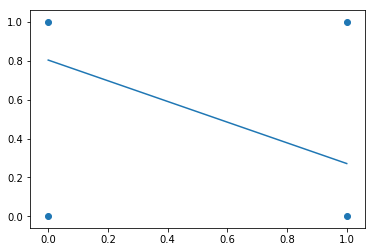


------------ delta ------------
-
dZ1: 
[[ 0.08971939  0.13197531  0.11395949 -0.09321385]]
sig_prime1: 
[[0.23574025 0.24911311 0.24831357 0.2381926 ]]
dW1: 
[[0.00518641 0.00969037]]
db1: 
[[0.06061009]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32190829 0.60535743]]
b1: 
[[-0.49312358]]
--------------------------------
**************************************************


-> Epoca: 00065 - Erro: 0.19656 - Acurácia: 75%

y_hat: (1, 4) 
[[0.37915801 0.52802905 0.45730044 0.60686234]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



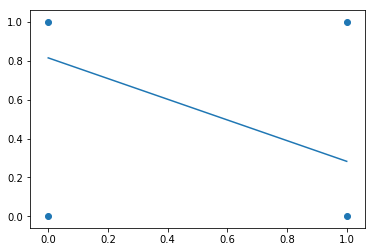


------------ delta ------------
-
dZ1: 
[[ 0.08925274  0.13159243  0.11349134 -0.09379496]]
sig_prime1: 
[[0.23539721 0.24921437 0.24817675 0.23858044]]
dW1: 
[[0.00492409 0.00944937]]
db1: 
[[0.06013539]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32141588 0.60441249]]
b1: 
[[-0.49913712]]
--------------------------------
**************************************************


-> Epoca: 00066 - Erro: 0.19582 - Acurácia: 75%

y_hat: (1, 4) 
[[0.37774347 0.52629456 0.45568627 0.60508329]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



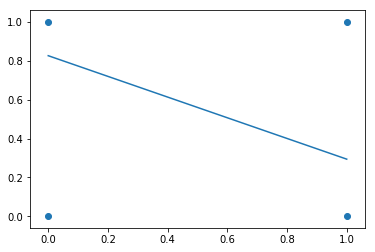


------------ delta ------------
-
dZ1: 
[[ 0.08878986  0.13120976  0.11302673 -0.09436831]]
sig_prime1: 
[[0.23505334 0.2493086  0.24803629 0.2389575 ]]
dW1: 
[[0.00466461 0.00921036]]
db1: 
[[0.05966451]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32094942 0.60349145]]
b1: 
[[-0.50510357]]
--------------------------------
**************************************************


-> Epoca: 00067 - Erro: 0.19509 - Acurácia: 75%

y_hat: (1, 4) 
[[0.37634206 0.52457715 0.45409113 0.60332466]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



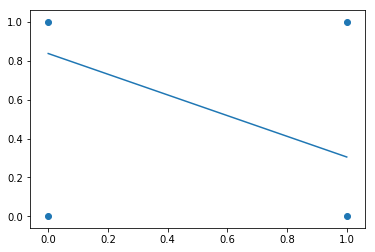


------------ delta ------------
-
dZ1: 
[[ 0.08833076  0.13082742  0.11256573 -0.09493393]]
sig_prime1: 
[[0.23470871 0.24939596 0.24789238 0.23932401]]
dW1: 
[[0.00440795 0.00897337]]
db1: 
[[0.0591975]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32050863 0.60259412]]
b1: 
[[-0.51102332]]
--------------------------------
**************************************************


-> Epoca: 00068 - Erro: 0.19437 - Acurácia: 75%

y_hat: (1, 4) 
[[0.37495367 0.52287672 0.45251487 0.60158638]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



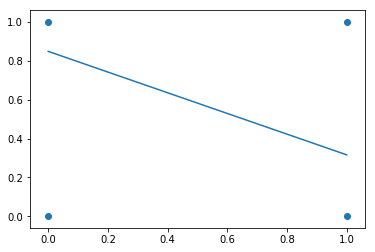


------------ delta ------------
-
dZ1: 
[[ 0.08787542  0.13044553  0.11210837 -0.09549186]]
sig_prime1: 
[[0.23436341 0.24947666 0.24774516 0.23968021]]
dW1: 
[[0.00415413 0.00873842]]
db1: 
[[0.05873437]]
--------------------------------

------------ params ------------
-
W1: 
[[0.32009321 0.60172028]]
b1: 
[[-0.51689676]]
--------------------------------
**************************************************


-> Epoca: 00069 - Erro: 0.19367 - Acurácia: 75%

y_hat: (1, 4) 
[[0.37357816 0.52119317 0.4509573  0.59986838]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



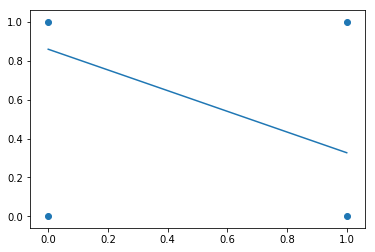


------------ delta ------------
-
dZ1: 
[[ 0.08742383  0.1300642   0.11165469 -0.09604211]]
sig_prime1: 
[[0.23401752 0.24955085 0.24759481 0.24002631]]
dW1: 
[[0.00390314 0.00850552]]
db1: 
[[0.05827515]]
--------------------------------

------------ params ------------
-
W1: 
[[0.3197029  0.60086972]]
b1: 
[[-0.52272427]]
--------------------------------
**************************************************


-> Epoca: 00070 - Erro: 0.19297 - Acurácia: 75%

y_hat: (1, 4) 
[[0.37221543 0.51952643 0.44941828 0.59817059]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



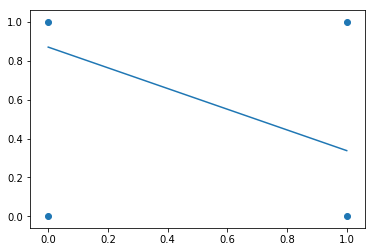


------------ delta ------------
-
dZ1: 
[[ 0.08697599  0.12968352  0.11120473 -0.09658473]]
sig_prime1: 
[[0.2336711  0.24961872 0.24744149 0.24036253]]
dW1: 
[[0.003655  0.0082747]]
db1: 
[[0.05781988]]
--------------------------------

------------ params ------------
-
W1: 
[[0.3193374  0.60004225]]
b1: 
[[-0.52850626]]
--------------------------------
**************************************************


-> Epoca: 00071 - Erro: 0.19229 - Acurácia: 75%

y_hat: (1, 4) 
[[0.37086535 0.51787638 0.44789761 0.59649293]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



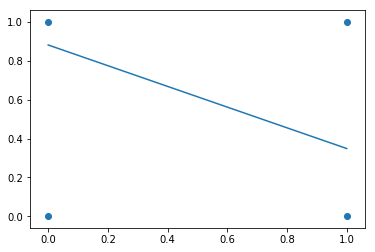


------------ delta ------------
-
dZ1: 
[[ 0.08653188  0.1293036   0.11075851 -0.09711976]]
sig_prime1: 
[[0.23332424 0.24968044 0.24728534 0.24068911]]
dW1: 
[[0.00340969 0.00804596]]
db1: 
[[0.05736856]]
--------------------------------

------------ params ------------
-
W1: 
[[0.31899643 0.59923766]]
b1: 
[[-0.53424311]]
--------------------------------
**************************************************


-> Epoca: 00072 - Erro: 0.19162 - Acurácia: 75%

y_hat: (1, 4) 
[[0.36952779 0.51624292 0.44639513 0.59483532]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



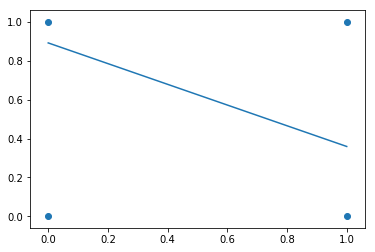


------------ delta ------------
-
dZ1: 
[[ 0.08609148  0.12892453  0.11031608 -0.09764723]]
sig_prime1: 
[[0.232977   0.24973617 0.24712652 0.24100626]]
dW1: 
[[0.00316721 0.00781933]]
db1: 
[[0.05692121]]
--------------------------------

------------ params ------------
-
W1: 
[[0.31867971 0.59845573]]
b1: 
[[-0.53993524]]
--------------------------------
**************************************************


-> Epoca: 00073 - Erro: 0.19096 - Acurácia: 75%

y_hat: (1, 4) 
[[0.36820265 0.51462595 0.44491067 0.59319765]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



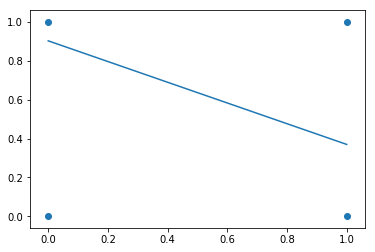


------------ delta ------------
-
dZ1: 
[[ 0.08565478  0.1285464   0.10987744 -0.09816718]]
sig_prime1: 
[[0.23262946 0.24978608 0.24696517 0.2413142 ]]
dW1: 
[[0.00292756 0.0075948 ]]
db1: 
[[0.05647786]]
--------------------------------

------------ params ------------
-
W1: 
[[0.31838695 0.59769625]]
b1: 
[[-0.54558302]]
--------------------------------
**************************************************


-> Epoca: 00074 - Erro: 0.19031 - Acurácia: 75%

y_hat: (1, 4) 
[[0.36688979 0.51302536 0.44344405 0.59157983]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



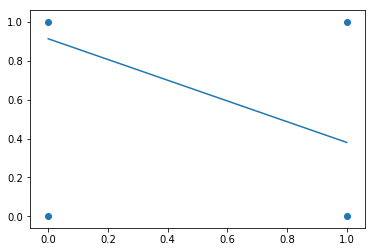


------------ delta ------------
-
dZ1: 
[[ 0.08522177  0.1281693   0.10944262 -0.09867968]]
sig_prime1: 
[[0.23228167 0.24983034 0.24680142 0.24161313]]
dW1: 
[[0.00269074 0.00737241]]
db1: 
[[0.0560385]]
--------------------------------

------------ params ------------
-
W1: 
[[0.31811788 0.596959  ]]
b1: 
[[-0.55118687]]
--------------------------------
**************************************************


-> Epoca: 00075 - Erro: 0.18968 - Acurácia: 75%

y_hat: (1, 4) 
[[0.36558909 0.51144104 0.44199509 0.58998177]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



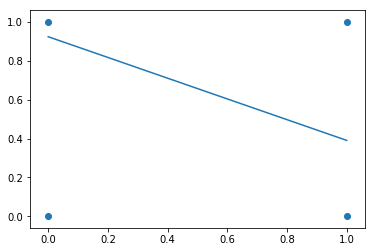


------------ delta ------------
-
dZ1: 
[[ 0.08479243  0.12779331  0.10901165 -0.09918476]]
sig_prime1: 
[[0.23193371 0.2498691  0.24663543 0.24190328]]
dW1: 
[[0.00245672 0.00715214]]
db1: 
[[0.05560316]]
--------------------------------

------------ params ------------
-
W1: 
[[0.31787221 0.59624379]]
b1: 
[[-0.55674719]]
--------------------------------
**************************************************


-> Epoca: 00076 - Erro: 0.18905 - Acurácia: 75%

y_hat: (1, 4) 
[[0.36430043 0.50987287 0.44056361 0.58840335]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



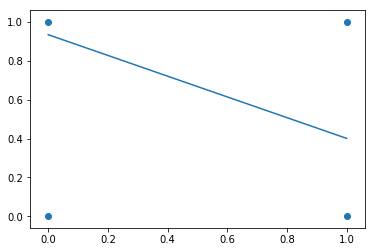


------------ delta ------------
-
dZ1: 
[[ 0.08436674  0.12741852  0.10858453 -0.09968247]]
sig_prime1: 
[[0.23158563 0.24990253 0.24646732 0.24218485]]
dW1: 
[[0.00222551 0.00693401]]
db1: 
[[0.05517183]]
--------------------------------

------------ params ------------
-
W1: 
[[0.31764966 0.59555039]]
b1: 
[[-0.56226437]]
--------------------------------
**************************************************


-> Epoca: 00077 - Erro: 0.18843 - Acurácia: 75%

y_hat: (1, 4) 
[[0.36302369 0.50832074 0.43914944 0.58684446]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



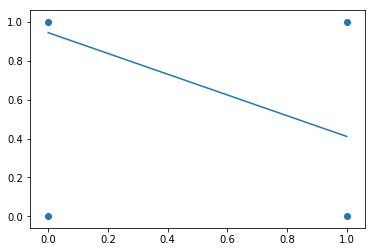


------------ delta ------------
-
dZ1: 
[[ 0.08394469  0.12704499  0.10816128 -0.10017288]]
sig_prime1: 
[[0.23123749 0.24993077 0.24629721 0.24245804]]
dW1: 
[[0.0019971  0.00671803]]
db1: 
[[0.05474452]]
--------------------------------

------------ params ------------
-
W1: 
[[0.31744995 0.59487859]]
b1: 
[[-0.56773882]]
--------------------------------
**************************************************


-> Epoca: 00078 - Erro: 0.18782 - Acurácia: 75%

y_hat: (1, 4) 
[[0.36175874 0.50678452 0.4377524  0.58530499]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



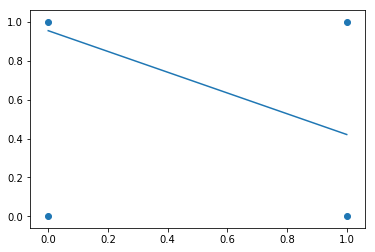


------------ delta ------------
-
dZ1: 
[[ 0.08352624  0.1266728   0.10774191 -0.10065604]]
sig_prime1: 
[[0.23088935 0.24995397 0.24612524 0.24272306]]
dW1: 
[[0.00177147 0.00650419]]
db1: 
[[0.05432123]]
--------------------------------

------------ params ------------
-
W1: 
[[0.3172728  0.59422817]]
b1: 
[[-0.57317095]]
--------------------------------
**************************************************


-> Epoca: 00079 - Erro: 0.18723 - Acurácia: 75%

y_hat: (1, 4) 
[[0.36050547 0.50526411 0.4363723  0.58378481]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



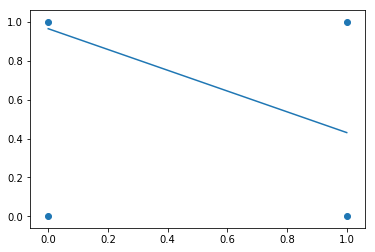


------------ delta ------------
-
dZ1: 
[[ 0.08311139  0.12630203  0.10732643 -0.10113201]]
sig_prime1: 
[[0.23054128 0.24997229 0.24595152 0.24298011]]
dW1: 
[[0.0015486 0.0062925]]
db1: 
[[0.05390196]]
--------------------------------

------------ params ------------
-
W1: 
[[0.31711794 0.59359892]]
b1: 
[[-0.57856114]]
--------------------------------
**************************************************


-> Epoca: 00080 - Erro: 0.18664 - Acurácia: 75%

y_hat: (1, 4) 
[[0.35926374 0.50375937 0.43500897 0.5822838 ]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



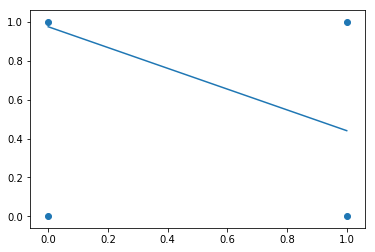


------------ delta ------------
-
dZ1: 
[[ 0.08270011  0.12593272  0.10691484 -0.10160085]]
sig_prime1: 
[[0.23019331 0.24998587 0.24577617 0.24322938]]
dW1: 
[[0.0013285  0.00608297]]
db1: 
[[0.0534867]]
--------------------------------

------------ params ------------
-
W1: 
[[0.31698509 0.59299062]]
b1: 
[[-0.58390981]]
--------------------------------
**************************************************


-> Epoca: 00081 - Erro: 0.18606 - Acurácia: 75%

y_hat: (1, 4) 
[[0.35803344 0.50227019 0.43366223 0.58080184]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



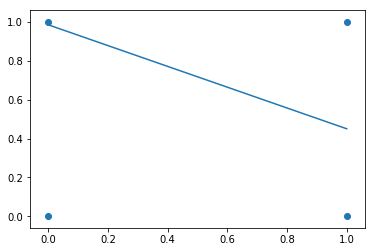


------------ delta ------------
-
dZ1: 
[[ 0.08229237  0.12556496  0.10650714 -0.10206262]]
sig_prime1: 
[[0.2298455  0.24999485 0.2455993  0.24347106]]
dW1: 
[[0.00111113 0.00587558]]
db1: 
[[0.05307546]]
--------------------------------

------------ params ------------
-
W1: 
[[0.31687398 0.59240306]]
b1: 
[[-0.58921736]]
--------------------------------
**************************************************


-> Epoca: 00082 - Erro: 0.18550 - Acurácia: 75%

y_hat: (1, 4) 
[[0.35681445 0.50079643 0.43233189 0.5793388 ]] --> [[0. 1. 0. 1.]]
                                                    [[0 0 0 1]]



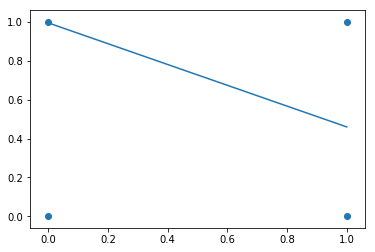


------------ delta ------------
-
dZ1: 
[[ 0.08188817  0.12519879  0.10610334 -0.10251739]]
sig_prime1: 
[[0.2294979  0.24999937 0.24542103 0.24370536]]
dW1: 
[[0.00089649 0.00567035]]
db1: 
[[0.05266823]]
--------------------------------

------------ params ------------
-
W1: 
[[0.31678433 0.59183603]]
b1: 
[[-0.59448418]]
--------------------------------
**************************************************


-> Epoca: 00083 - Erro: 0.18494 - Acurácia: 100%

y_hat: (1, 4) 
[[0.35560664 0.49933796 0.43101778 0.57789453]] --> [[0. 0. 0. 1.]]
                                                    [[0 0 0 1]]



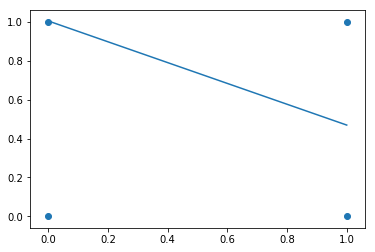

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

reta = lambda x, w1, w2, b: (-(b / w2) / (b / w1))*x + (-b / w2)
pontos = np.linspace(0, 1)


learning_rate = 0.1
epochs = 500
print(f"\nTreinando com taxa de aprendizado = {learning_rate} e {epochs} épocas:")

# Inicializa os pesos aleatoriamente
nn_params_values = init_layers(nn_architecture)
print()
print_params(nn_params_values, nn_architecture)
print()

print()
print()
print("*" * 50)
for i in range(epochs):
    
    # executa uma passagem na rede
    y_hat, cache = nn_forward_full(X, nn_params_values, nn_architecture)
    
    # Calcula o erro e a acuracia da previsao realizada
    error = mean_square_error(y, y_hat)
    acuracia = get_accuracy_value(y, y_hat)*100
    print("-> Epoca: {:05} - Erro: {:.5f} - Acurácia: {:.0f}%".format((i+1), error, acuracia))
    print()
    
    print(f"y_hat: {y_hat.shape} \n{y_hat} --> {convert_prob_into_class(y_hat)}")
    print(f"                                                    {y}")
    print()
    
    # exibe linha de separacao
    for layer_idx, layer in enumerate(nn_architecture, 1):
        w1 = nn_params_values['W' + str(layer_idx)][0, 0]
        w2 = nn_params_values['W' + str(layer_idx)][0, 1]
        b  = nn_params_values['b' + str(layer_idx)][0, 0]
        plt.plot(pontos, reta(pontos, w1, w2, b))
        plt.scatter(X[0,:], X[1,:])
        plt.show() 
        
    if (error < 0.06 or acuracia == 100):
        break
    
    # Calcula os ajustes nos pesos por meio do backpropagation
    delta_values = full_backward_propagation(y_hat, y, cache, nn_architecture)
    print()
    print_delta(delta_values, nn_architecture)

    # Atualiza os pesos
    nn_params_values = nn_update_parameters(nn_params_values, delta_values, nn_architecture, learning_rate)
    print()
    print_params(nn_params_values, nn_architecture)
    
    print("*" * 50)
    print()
    print()

In [39]:
# executa uma passagem na rede
X = np.array([[0, 1]]).T
print(f'X.shape: {X.shape} \n{X.T}')
print()

y = np.array([[0]])
print(f'y.shape: {y.shape} \n{y.T}')
print()

y_hat, cache = nn_forward_full(X, nn_params_values, nn_architecture)
print(f"y_hat: {y_hat.shape} \n{y_hat} --> {convert_prob_into_class(y_hat)}")
print()

# Calcula o erro e a acuracia da previsao realizada
error = mean_square_error(y, y_hat)
acuracia = get_accuracy_value(y, y_hat)*100
print("-> Erro: {:.5f} - Acurácia: {:.0f}%".format(error, acuracia))

X.shape: (2, 1) 
[[0 1]]

y.shape: (1, 1) 
[[0]]

y_hat: (1, 1) 
[[0.49500129]] --> [[0.]]

-> Erro: 0.24503 - Acurácia: 100%


### Aplicando a convolução em uma imagem real

In [ ]:
from imageio import imread
from PIL import Image

qtd_filtros = 5
img_size = 200

pedrita = imread('images/pedrita.jpg')
pedrita_resized = np.array(Image.fromarray(pedrita).resize((img_size, img_size)))
print(f'pedrita.shape: {pedrita_resized.shape}')
print('-')

# imagem de entrada (1 imagem de 3 canais de tamanho img_size x img_size)
X = np.zeros((1, 3, img_size, img_size))
X[0, :, :, :] = pedrita_resized.transpose((2, 0, 1))
print(f'X.shape: {X.shape}')

# n filtros 3x3x3 (canais da imagem de entrada x altura filtro x largura filtro)
W = np.random.randn(qtd_filtros, 3, 3, 3)
print(f'W.shape: {W.shape}')

# seta o primeiro filtro hardcode (converte para niveis de cinza)
W[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
W[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
W[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# bias utilizado
b = np.random.randn(qtd_filtros, 1, 1, 1)
print(f'b.shape: {b.shape}')

hparameters = {"pad" : 0, "stride": 1}
CONV, cache_conv = conv_forward(X, W, b, hparameters)
ACTV = relu(CONV)

hparameters = {"stride" : 2, "f": 2}
POOL, cache_pool = pool_forward(ACTV, hparameters)

print('-')
print(f'CONV.shape: {CONV.shape}')
print(f'POOL.shape: {POOL.shape}')
show_img(pedrita_resized, CONV[0][0], POOL[0][0], 'Imagem de entrada', 'Convolução W1', 'Pooling W1', show_px_value = False)